## Project 2 : Multinomial Naive Bayes Classifier for Fake News Recognition

#### Group Members: 
- Jelin Raphael Akkara
- Amirhosseign Rostami

## Loading Libraries

In [75]:
library(tidyverse)  #Contains dplyr
library(SnowballC)  #Used for stemming
library(udpipe)     #Used for lemmatization
library(tidytext)   #Used for tokenization
library(caTools)    #Used for sample.split
library(gridExtra)  #Used for arranging plots in grids
library(viridis)    #Used for colormap

In [76]:
ud_model <- udpipe_load_model('english-ewt-ud-2.5-191206.udpipe')

## Cleaning/Preprocessing Data

#### Loading the Data

In [77]:
#First Dataset
df_train_valid <- read.csv('archive/train.csv')  
df_test <- read.csv('archive/test.csv')

reorder_labels <- c(4, 1, 0, 2, 3, 5)

labels <- factor(0:5, levels = reorder_labels)
names <- c('Barely_True', 'False', 'Half_True', 'Mostly_True', 'Not_Known', 'True')

labels_descrip <- tibble(Labels = labels, Name = factor(names, levels = names[reorder_labels + 1]))

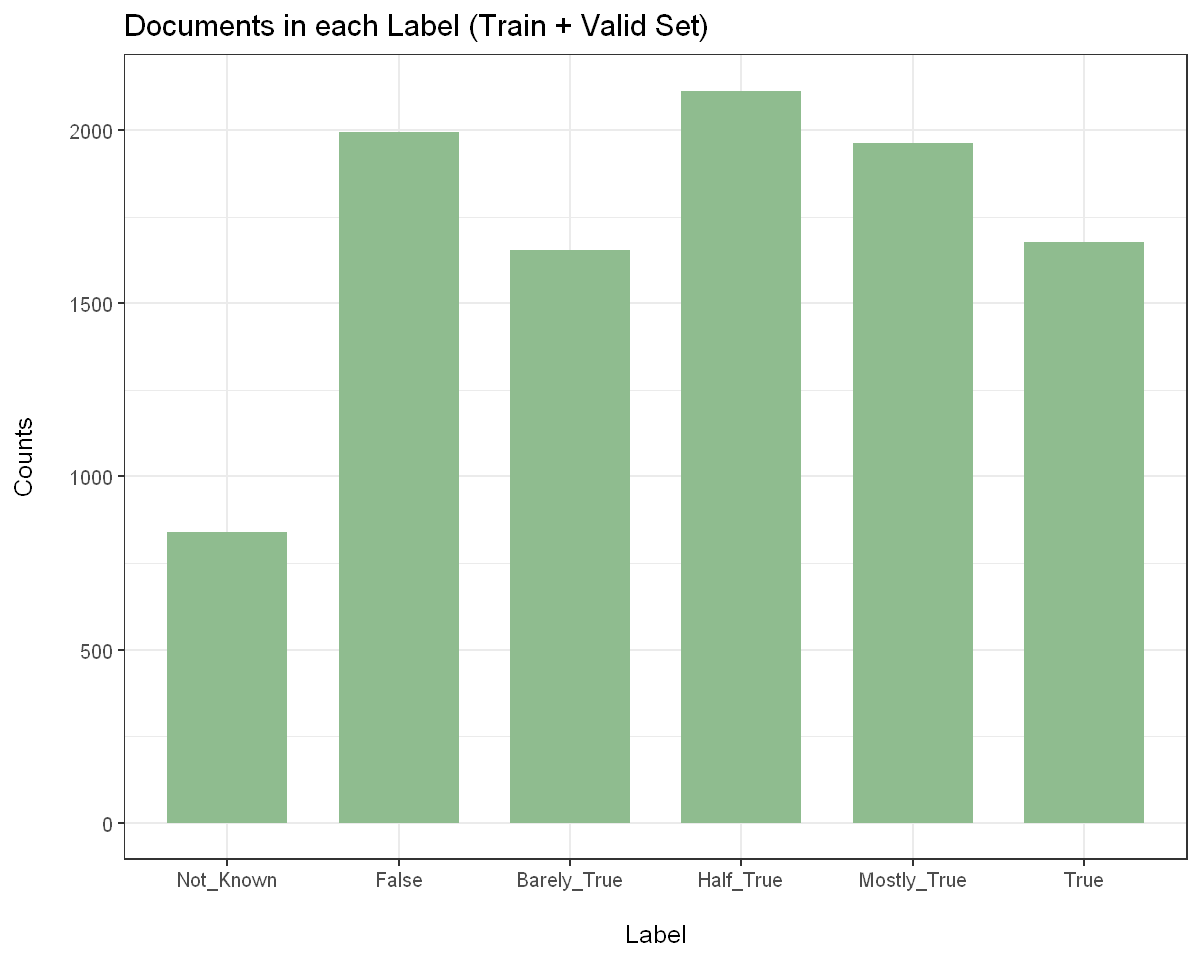

In [78]:
options(repr.plot.height=8, repr.plot.width=10)

#Get counts per label
label_counts <- df_train_valid %>%
                    group_by(Labels) %>%
                    summarise(counts = n()) %>%
                    mutate(Labels = factor(Labels, levels = reorder_labels)) %>%
                    left_join(labels_descrip, by='Labels')

ggplot(label_counts, aes(x = Name, y = counts)) +
            theme_bw(base_size = 15) +
            geom_bar(stat = 'identity', fill='darkseagreen', width=0.7) +
            ggtitle('Documents in each Label (Train + Valid Set)') +
            xlab('\nLabel') +
            ylab('Counts\n')

#### Split into Training, Validation Sets

In [79]:
set.seed(100)
split_perc <- 0.8

split_bool <- sample.split(df_train_valid$Text, SplitRatio = split_perc)
df_train <- subset(df_train_valid, split_bool == TRUE)
df_valid <- subset(df_train_valid, split_bool == FALSE)

In [80]:
prepare_tibble <- function(df, dataset_num, remove_tag=FALSE, factor_labels=FALSE){
    
    tb <- df %>% as_tibble #Converts to tibble

    if (dataset_num == 1){
        tb <- tb %>%
                add_column(document_id = 1:nrow(df))        %>%     #Adds column labelling document id
                relocate(document_id)                               #Repositions document id column
    }

    if (remove_tag){
        tb <- tb %>% select(-c(Text_Tag))
        }
    
    if (factor_labels){
        tb <- tb %>% mutate(Labels = as.factor(Labels))
    }
    
    return(tb)            
}

In [83]:
tb_train <- prepare_tibble(df_train, dataset_num=1, factor_labels = TRUE, remove_tag = TRUE)
tb_valid <- prepare_tibble(df_valid, dataset_num=1, factor_labels = TRUE, remove_tag = TRUE)
tb_test <- prepare_tibble(df_test, dataset_num=1, remove_tag = TRUE)

print(dim(tb_train))
print(dim(tb_valid))
print(dim(tb_test))

[1] 8192    3
[1] 2048    3
[1] 1267    2


In [84]:
head(tb_train, 3)

document_id,Labels,Text
<int>,<fct>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran."""


#### Cleaning using tidyverse

In [85]:
clean_tibble <- function(tb, stem=TRUE, lem=FALSE){

    if (lem){
        tb <- tb %>%
                rowwise() %>%      #Required for lemmatization
                mutate(Text = paste(udpipe(Text, object=ud_model)$lemma, collapse=' '))     #Lemmatization
    }

    tb_clean <- tb %>% 
                    mutate(Text = tolower(Text))                                            %>%     #Lowering Case 
                    mutate(Text =  str_replace_all(Text, "[[:punct:]]", ""))                %>%     #Removes Punctuations
                    mutate(Text = str_remove_all(Text, '\\d+'))                             %>%     #Removes Numbers
                    mutate(Text = str_squish(Text))                                                 #Removes Extra Whitespaces

    tb_tokenize <- tb_clean %>% 
                    unnest_tokens(output='word', Text) %>%      #Tokenize
                    anti_join(stop_words)                       #Remove Stop Words
    
    if (stem){
        tb_tokenize <- tb_tokenize %>%
                        mutate(word = wordStem(word))               #Stemming
    }
                    

    return(tb_tokenize)
}

In [86]:
tb_train_clean <- clean_tibble(tb_train, stem=TRUE, lem=FALSE)
vocab <- unique(tb_train_clean$word)

Joining with `by = join_by(word)`


In [87]:
head(tb_train_clean, 3)

document_id,Labels,word
<int>,<fct>,<chr>
1,1,anni
1,1,list
1,1,polit


In [88]:
length(vocab)

[1] 7417

-------------------

## Feature Selection with Mutual Information

In [89]:
implement_feature_selection <- function(tb, tb_clean, vocab, top_k=100, laplace_factor=1, keep_ties=FALSE){

    label_counts <- table(tb$Labels)
    label_vals <- as.data.frame(label_counts)[, 1]

    tb_ref <- tibble(Labels = rep(as.factor(label_vals), each=length(vocab)), 
                    word = rep(vocab, times=length(label_vals)))

    # N_a1 : Get the number of docs in each label irrespective of the words
    tb_N_a1 <- tb %>%
                group_by(Labels) %>%
                summarise(N_a1 = n())

    #N_11 : Number of docs containing specific combination of (Label, Word)
    tb_N_11 <- tb_clean %>%
                    group_by(across(all_of(c('Labels', 'word')))) %>%
                    summarise(N_11 = length(unique(document_id))) 

    #Joins N_11, N_a1 to tb_ref to create tb_mi that tracks all values for combinations of (Label, Word)
    tb_mi <- tb_ref %>%
                left_join(tb_N_11, by=c('Labels', 'word')) %>%
                replace_na(list(N_11 = 0)) %>%          #Replace possible NA with zero

                left_join(tb_N_a1, by='Labels') %>%     #Add N_a1
                mutate(N_01 = N_a1 - N_11)              #Add N_01

    #N_1a : Number of documents containing a word irrespective of the class
    tb_N_1a <- tb_clean %>%
                group_by(word) %>%
                summarise(N_1a = length(unique(document_id)))

    #N : Total Number of documents
    tb_N <- tibble(N = nrow(tb)) %>%
                slice(rep(1:n(), times=nrow(tb_mi)))


    tb_mi <- tb_mi %>%
                left_join(tb_N_1a, by='word') %>%       #Add N_1a column
                replace_na(list(N_1a = 0)) %>%          #Replace possible NA with zero

                mutate(N_10 = N_1a - N_11) %>%          #Add N_10 column
                add_column(N = tb_N$N) %>%              #Add N column
                mutate(N_0a = N - N_1a) %>%             #Add N_0a column
                mutate(N_00 = N_0a - N_01) %>%          #Add N_00 column
                mutate(N_a0 = N_00 + N_10) %>%          #Add N_a0 column

                #Laplace smoothing over all columns
                mutate(across(where(is.integer), ~ .x + laplace_factor)) %>%

                #Add Mutual Information Score
                mutate(mi_score = ( (N_11/N) * log2((N*N_11)/(N_1a * N_a1)) ) + 
                                    ( (N_01/N) * log2((N*N_01) / (N_0a * N_a1))) +
                                    ( (N_10/N) * log2((N*N_10) / (N_1a * N_a0))) +
                                    ( (N_00/N) * log2((N*N_00) / (N_0a * N_a0)) )) %>%
                
                select(Labels, word, mi_score) %>%

                #Selects top_k words for each label (with the option of breaking ties)
                group_by(Labels) %>%
                slice_max(n=top_k, order_by=mi_score, with_ties = keep_ties) %>% #Breaks ties wrt position
                select(Labels, word)

    return(tb_mi)
}

In [91]:
tb_features <- implement_feature_selection(tb_train, tb_train_clean, vocab, 
                                            top_k = 500, 
                                            laplace_factor = 1,
                                            keep_ties = FALSE)

dim(tb_features)
head(tb_features, 3)

`summarise()` has grouped output by 'Labels'. You can override using the
`.groups` argument.


[1] 3000    2

Labels,word
<fct>,<chr>
0,obamacar
0,uranium
0,benghazi


In [ ]:
#Get most occuring words in a Label
tb_features %>% 
    left_join(labels_descrip, by='Labels') %>%
    filter(Labels == 0) %>%
    select(Labels, Name, word)

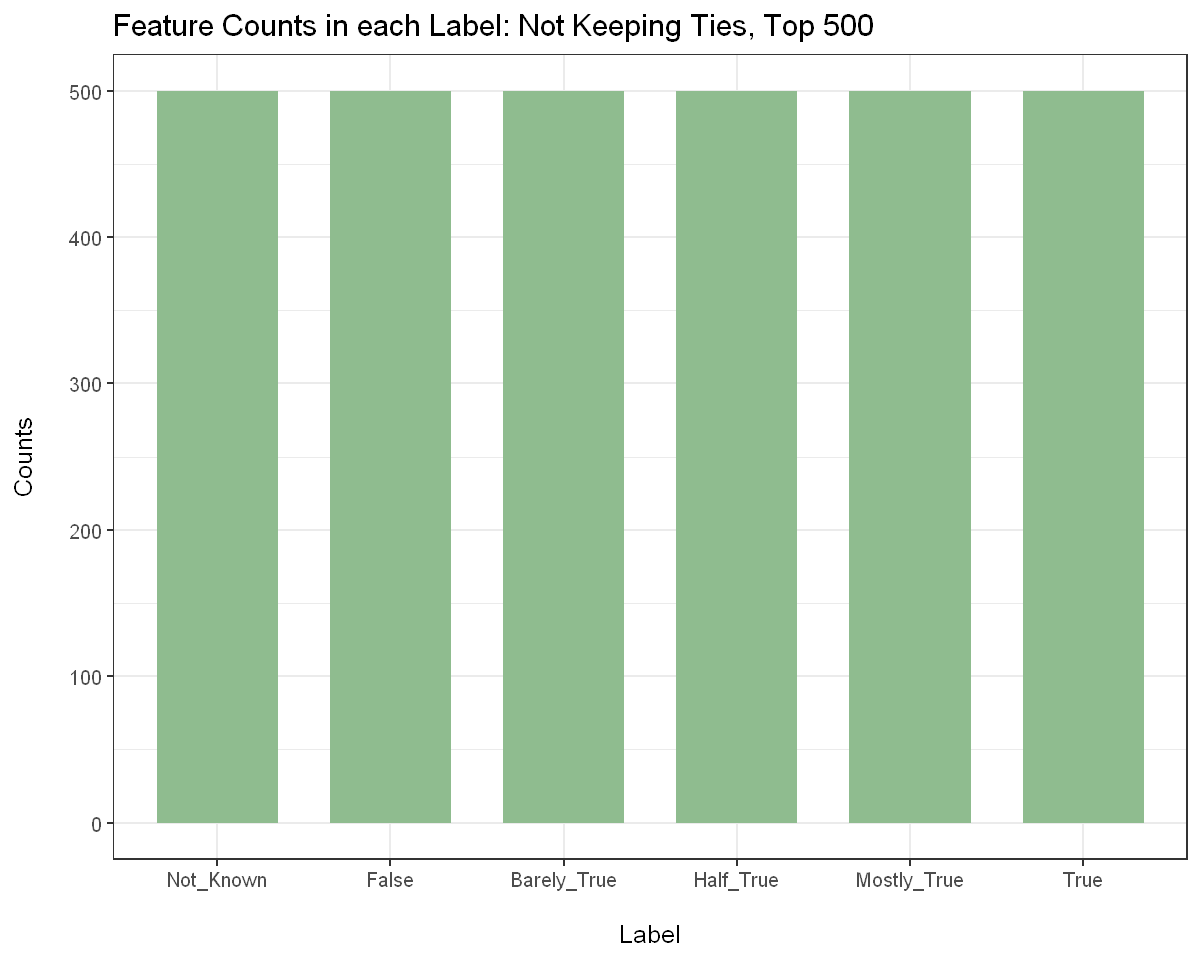

In [92]:
options(repr.plot.height = 8, repr.plot.width = 10)

#Gets and plots feature counts in each label
features_per_label <- tb_features %>% 
                        group_by(Labels) %>% 
                        summarise(counts = n()) %>%
                        left_join(labels_descrip, by='Labels')

ggplot(features_per_label, aes(x = Name, y = counts)) +
    theme_bw(base_size = 15) +
    geom_bar(stat = 'identity', fill='darkseagreen', width=0.7) +
    ggtitle('Feature Counts in each Label: Not Keeping Ties, Top 500') +
    xlab('\nLabel') +
    ylab('Counts\n')

In [93]:
#Reduced cleaned training set after feature selection
tb_train_clean_reduced <- tb_train_clean %>%
                            inner_join(tb_features, by=c('Labels', 'word'))

dim(tb_train_clean_reduced)

[1] 13792     3

## Building and Training Model

In [94]:
build_mnb_model <- function(tb, tb_clean, laplace_factor=1){

    vocab <- unique(tb_clean$word)

    #Get priors : Number of docs in label / Total number of docs    
    label_counts <- table(tb$Labels)
    label_vals <- as.data.frame(label_counts)[, 1]
    label_priors <- tibble(Labels = as.factor(label_vals), 
                            prior = as.double(label_counts / sum(label_counts)) )

    #Get reference tb with all labels, words
    tb_ref <- tibble(Labels = rep(as.factor(label_vals), each=length(vocab)), 
                        word = rep(vocab, times=length(label_vals)))

    #Get tb with word occurrences in labels
    tb_counts <- tb_clean %>%
                    group_by(Labels) %>%
                    count(Labels, word)
    
    #Update tb_ref with counts by left joining the tb_counts
    tb_cond_probs <- tb_ref %>%
                    left_join(tb_counts, by=c('Labels', 'word')) %>%
                    replace_na(list(n = 0)) %>%
                    
                    #Get conditional probabilites for vocab in each label
                    mutate(log_cond_prob = log((n + laplace_factor) / (sum(n) + (laplace_factor * n_distinct(word))))) %>%

                    select(Labels, word, log_cond_prob)

    return (list(prior = label_priors, cond = tb_cond_probs, vocab = vocab))
}

In [95]:
#Passsing uncleaned tibble, returns prior, vocabulary and conditional probability of all words for each label
#We use the uncleaned tibble to get priors (cleaned tibble will not return correct priors)
#mnb_model <- build_mnb_model(tb_train, tb_train_clean_reduced, vocab, laplace_factor = 1)
mnb_model <- build_mnb_model(tb_train, tb_train_clean_reduced, laplace_factor = 1)

tb_priors <- mnb_model$prior
tb_cond <- mnb_model$cond
vocab <- mnb_model$vocab

In [96]:
print(dim(tb_priors))
print(dim(tb_cond))
print(length(vocab))

[1] 6 2
[1] 17370     3
[1] 2895


## Validating / Testing Model

In [97]:
predict_labels <- function(tb, tb_priors, tb_cond, remove_perc=0.75, keep_ties=FALSE){

    #Clean, tokenize tibble
    tb_clean <- tb %>% clean_tibble

    #Get predictions for words in vocabulary
    label_predictions <- tb_clean %>%
                            select(document_id, word) %>%   #Only these two columns are needed for making predictions

                            #Assign conditional probabilities to present words
                            #NA values mean out of vocabulary words
                            left_join(tb_cond, by='word', multiple='all') %>%   

                            #Now, we don't care for the words.  We group by (doc, label) and sum the log_cond_prob for each label in a doc
                            #Also, it adds a new column that gets the number of words present in (doc, label). This helps in getting the 
                            #percentage of new words in each document
                            group_by(across(all_of(c('document_id', 'Labels')))) %>%
                            summarise(log_likelihood = sum(log_cond_prob), counts=n())

    #Using the counts column, we can get the percentage of out of vocab words in each document
    #If the number of such words is high (> remove_perc), then we ignore the document
    #This is done so that there is a certain degree of reliability for the predictions.
    #It should not happend that the label was predicted using a single word that is not really relevant to the document.
    delete_docs <- label_predictions %>% 

                    #Groups by id and gets the na_ratio for each doc
                    group_by(document_id) %>% 
                    summarise(na_ratio = sum(counts[is.na(Labels)] / sum(counts) )) %>%
                    #summarise(sum_na = sum(counts[is.na(Labels)]), sum_total = sum(counts)) %>%
                    #mutate(na_ratio = sum_na / sum_total) %>%

                    #Filters to find docs with high na_ratio
                    filter(na_ratio >= remove_perc) %>%
                    select(document_id)

    #Removes the unreliable documents, and predicts labels for each document wrt log probability
    label_predictions_reliable <- label_predictions %>%

                                    #Removing unreliable documents
                                    filter(!document_id %in% delete_docs$document_id) %>%

                                    #Gets corresponding priors of labels
                                    left_join(tb_priors, by='Labels') %>%

                                    #Gets log probability of each label in each doc
                                    mutate(log_prob = log_likelihood + log(prior)) %>%
                                    
                                    #Select the label having highest log_prob for each doc
                                    slice_max(n=1, order_by=log_prob, with_ties=keep_ties) %>%

                                    #Select only the document_id and labels
                                    select(document_id, Labels)
    
    return (label_predictions_reliable)
}

In [98]:
tb_valid_preds <- predict_labels(tb_valid, tb_priors, tb_cond, 
                                    remove_perc=0.75, 
                                    keep_ties=TRUE )
                                    
print(dim(tb_valid_preds))

Joining with `by = join_by(word)`
`summarise()` has grouped output by 'document_id'. You can override using the
`.groups` argument.


[1] 1968    2


In [100]:
head(tb_valid, 3)

document_id,Labels,Text
<int>,<fct>,<chr>
1,0,Jim Dunnam has not lived in the district he represents for years now.
2,2,"Since 2000, nearly 12 million Americans have slipped out of the middle class and into poverty."
3,2,Rick Perry has never lost an election and remains the only person to have won the Texas governorship three times in landslide elections.


#### Get ratios for valid and removed documents

In [101]:
tb_valid_removed <- tb_valid %>% anti_join(tb_valid_preds, by='document_id')
dim(tb_valid_removed)

[1] 80  3

In [102]:
preds_present_ratio <- round(dim(tb_valid_preds)[1] / dim(tb_valid)[1], 6)
preds_removed_ratio <- round(dim(tb_valid_removed)[1] / dim(tb_valid)[1], 6)

tb_premoved <- tibble(Type = c('Valid Documents', 'Removed Documents'),
                        Counts = c(dim(tb_valid_preds)[1], dim(tb_valid_removed)[1]),
                        Percs = c(preds_present_ratio, preds_removed_ratio))
tb_premoved

Type,Counts,Percs
<chr>,<int>,<dbl>
Valid Documents,1968,0.960938
Removed Documents,80,0.039062


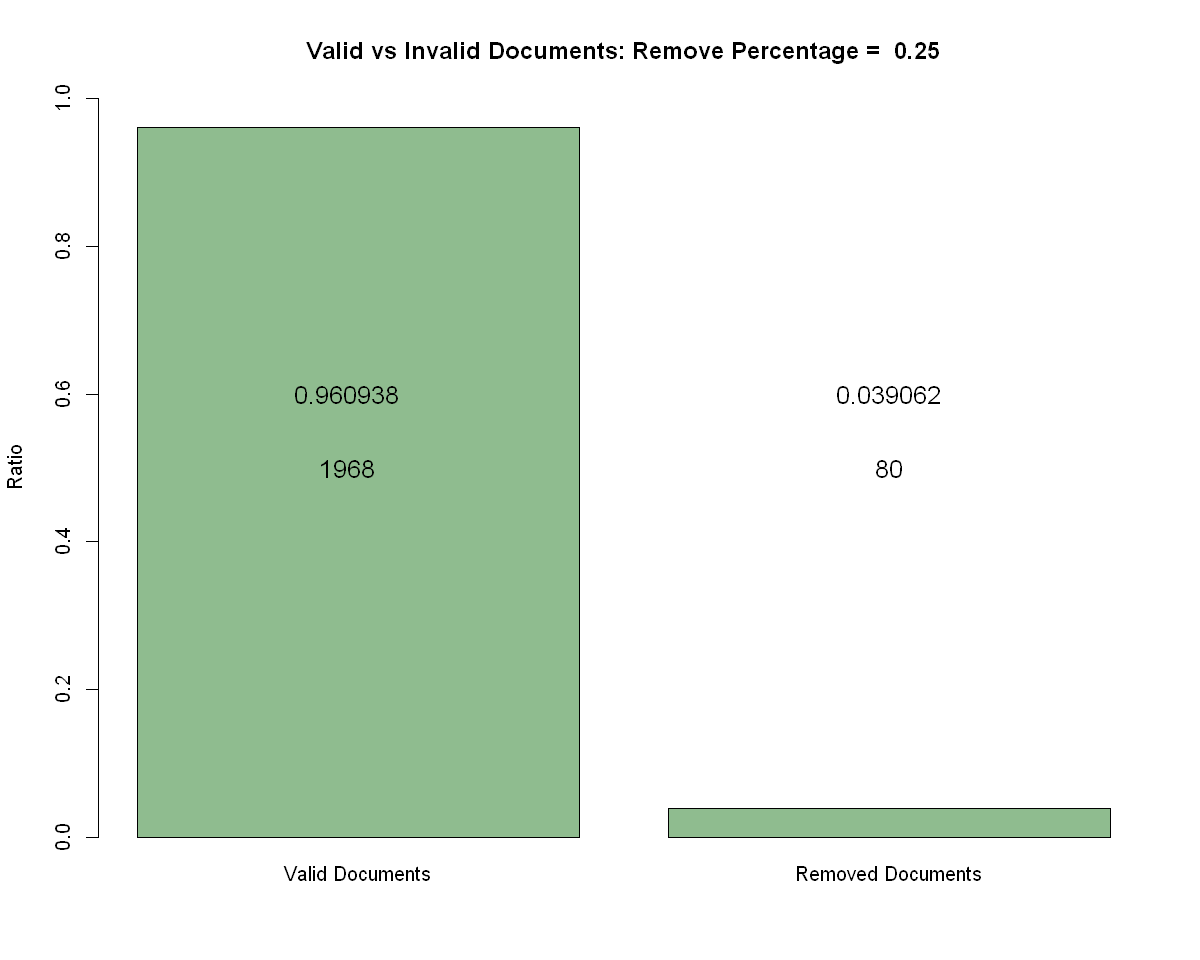

In [103]:
options(repr.plot.width=10, repr.plot.height=8)

barplot(tb_premoved$Percs, names=tb_premoved$Type, ylim=c(0, 1),
        main=paste('Valid vs Invalid Documents: Remove Percentage = ', 0.25), 
        ylab='Ratio',
        col='darkseagreen')

text(c(0.675, 1.9), 0.5, tb_premoved$Counts, cex=1.25)
text(c(0.675, 1.9), 0.6, tb_premoved$Percs, cex=1.25)


#### Get corresponding true labels for validation

In [104]:
tb_valid_compare <- tb_valid %>%

                        #Removes Text column, gets distinct rows
                        select(document_id, Labels) %>%

                        #Joins prediction tibble for comparison
                        right_join(tb_valid_preds, by='document_id', multiple='all') %>%
                        select(document_id, True_Label = Labels.x, Pred_Label = Labels.y)

head(tb_valid_compare, 3)
dim(tb_valid_compare)

document_id,True_Label,Pred_Label
<int>,<fct>,<fct>
1,0,5
2,2,3
3,2,3


[1] 1968    3

-----------

#### Testing Case

In [38]:
tb_test_preds <- predict_labels(tb_test, tb_priors, tb_cond, remove_perc = 0.75, keep_ties=FALSE )
print(dim(tb_test_preds))

Joining with `by = join_by(word)`
`summarise()` has grouped output by 'document_id'. You can override using the
`.groups` argument.


[1] 5150    2


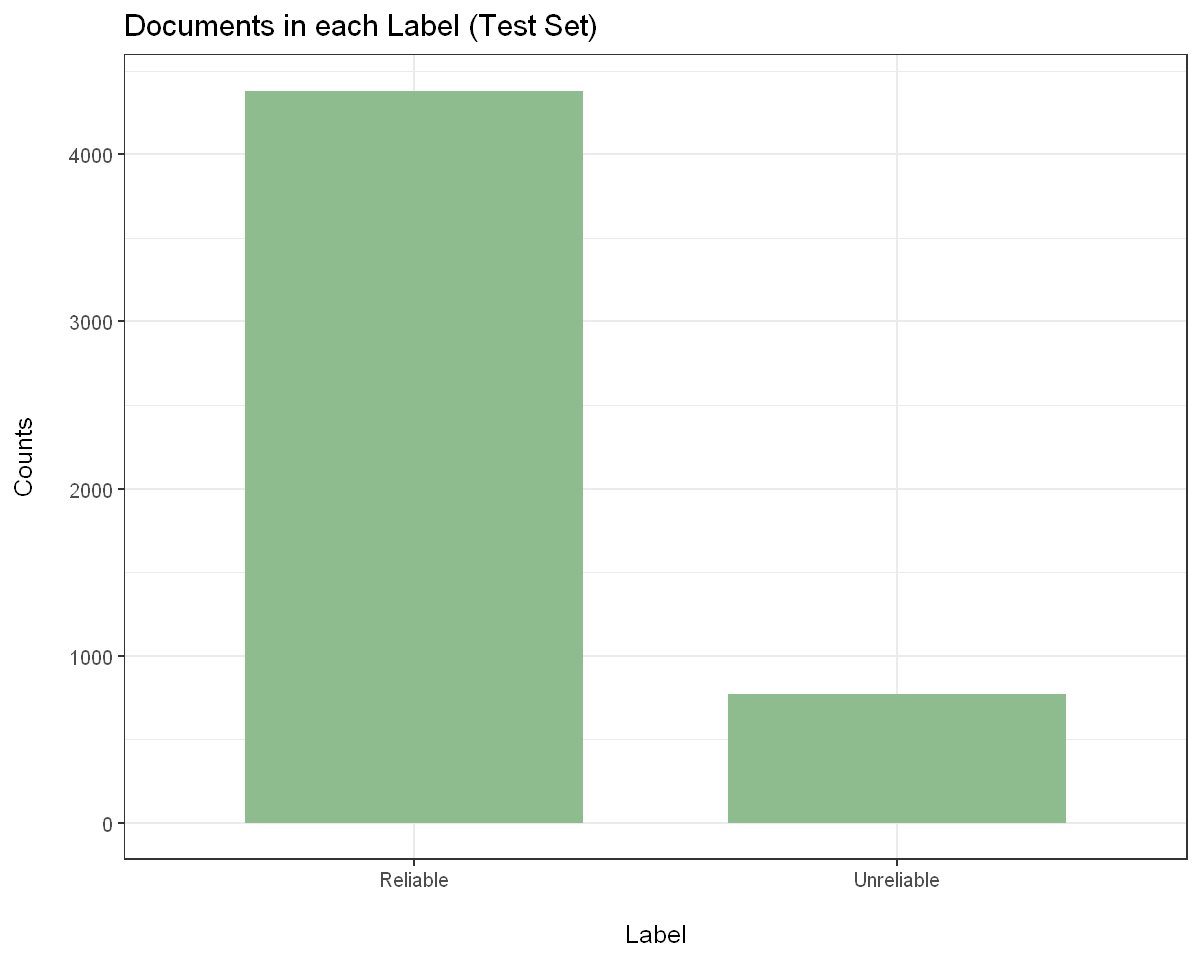

In [40]:
label_counts <- tb_test_preds %>%
                    group_by(Labels) %>%
                    summarise(counts = n()) %>%
                    mutate(Labels = factor(Labels, levels = reorder_labels)) %>%
                    left_join(labels_descrip, by='Labels')

ggplot(label_counts, aes(x = Name, y = counts)) +
            theme_bw(base_size = 15) +
            geom_bar(stat = 'identity', fill='darkseagreen', width=0.7) +
            ggtitle('Documents in each Label (Test Set)') +
            xlab('\nLabel') +
            ylab('Counts\n')

## Obtaining Metrics

In [105]:
# Function for getting tibble of metrics
get_metrics <- function(tb_compare, labels_descrip, beta_val=1){
    
    #Get confusion matrix
    confusion_mat <- table(tb_compare$True_Label, tb_compare$Pred_Label)

    #Get tp, tn, fp, fn
    mat_sum_rep <- rep(sum(confusion_mat), nrow(confusion_mat))

    tp_vals <- diag(confusion_mat)  %>% as.integer                              #Diagonal Elements give True Positive Values
    fp_vals <- (colSums(confusion_mat) - diag(confusion_mat)) %>% as.integer    #Col Sum - Diag gives False Positive Values
    fn_vals <- (rowSums(confusion_mat) - diag(confusion_mat)) %>% as.integer    #Row Sum - Diag gives False Negative Values
    tn_vals <- (mat_sum_rep - (tp_vals + fp_vals + fn_vals)) %>% as.integer     #Total Sum - (Rest of metrics) gives True Negative Values

    #Get total accuracy - check for correct predictions (both tp and tn) / total rows
    total_accuracy <- tb_compare %>% 
                        mutate(diff = ifelse((as.integer(True_Label) - as.integer(Pred_Label)) == 0, 1, 0)) %>%
                        summarise(total_acc = sum(diff) / nrow(tb_compare)) %>%
                        as.double

    #Put obtained metrics in a tibble, and obtain label-wise accuracy, precision, recall and f_beta score
    tb_metrics <- labels_descrip %>%
                        add_column(tp = tp_vals, fp = fp_vals, 
                            fn = fn_vals, tn = tn_vals) %>%

                            #Add total accuracy column
                            add_column(total_acc = rep(total_accuracy, nrow(labels_descrip))) %>%

                            #Add accuracy, precision, recall, f_beta values
                            mutate(acc = (tp + tn)/(tp + fp + tn + fn)) %>%
                            mutate(precision = tp / (tp + fp) ) %>%
                            mutate(recall = tp / (tp + fn) ) %>%
                            mutate(f_beta = ( (1 + beta_val^2) * (precision * recall) / ( ( beta_val^2 * precision ) + recall ))) %>%
                            replace_na(list(f_beta = 0))

    return (tb_metrics)
    
}

In [106]:
tb_metrics <- get_metrics(tb_valid_compare, labels_descrip, beta_val=0.5)

tb_metrics

Labels,Name,tp,fp,fn,tn,total_acc,acc,precision,recall,f_beta
<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Barely_True,58,206,282,1422,0.2027439,0.7520325,0.2196970,0.17058824,0.2077364
1,False,42,183,341,1402,0.2027439,0.7337398,0.1866667,0.10966057,0.1636789
2,Half_True,118,405,270,1175,0.2027439,0.6570122,0.2256214,0.30412371,0.2379032
3,Mostly_True,110,486,248,1124,0.2027439,0.6270325,0.1845638,0.30726257,0.2005835
4,Not_Known,11,32,161,1764,0.2027439,0.9019309,0.2558140,0.06395349,0.1598837
5,True,60,257,267,1384,0.2027439,0.7337398,0.1892744,0.18348624,0.1880878


## Plotting

##### Barplot: Accuracy, Precision, Recall, F_Beta

In [107]:
plot_bar <- function(tb, tb_metric_name, plot_metric_name, beta_val=1){

    main <- ggplot(tb, aes(x=Name, y=!!sym(tb_metric_name))) + 
                geom_bar(stat = 'identity', fill='darkseagreen', width=0.5) + 
                theme_bw(base_size = 15) +

                theme(plot.title = element_text(hjust = 0.5, face='bold', size=17)) +

                labs(x='\nLabel',
                        y=paste(plot_metric_name, '\n'),
                        title=paste(plot_metric_name, ' per Label'))

    if (tb_metric_name %in% c('total_acc', 'acc', 'precision', 'recall', 'f_beta')){
        main <- main + ylim(0, 1)
    }
    
    return (main)
}

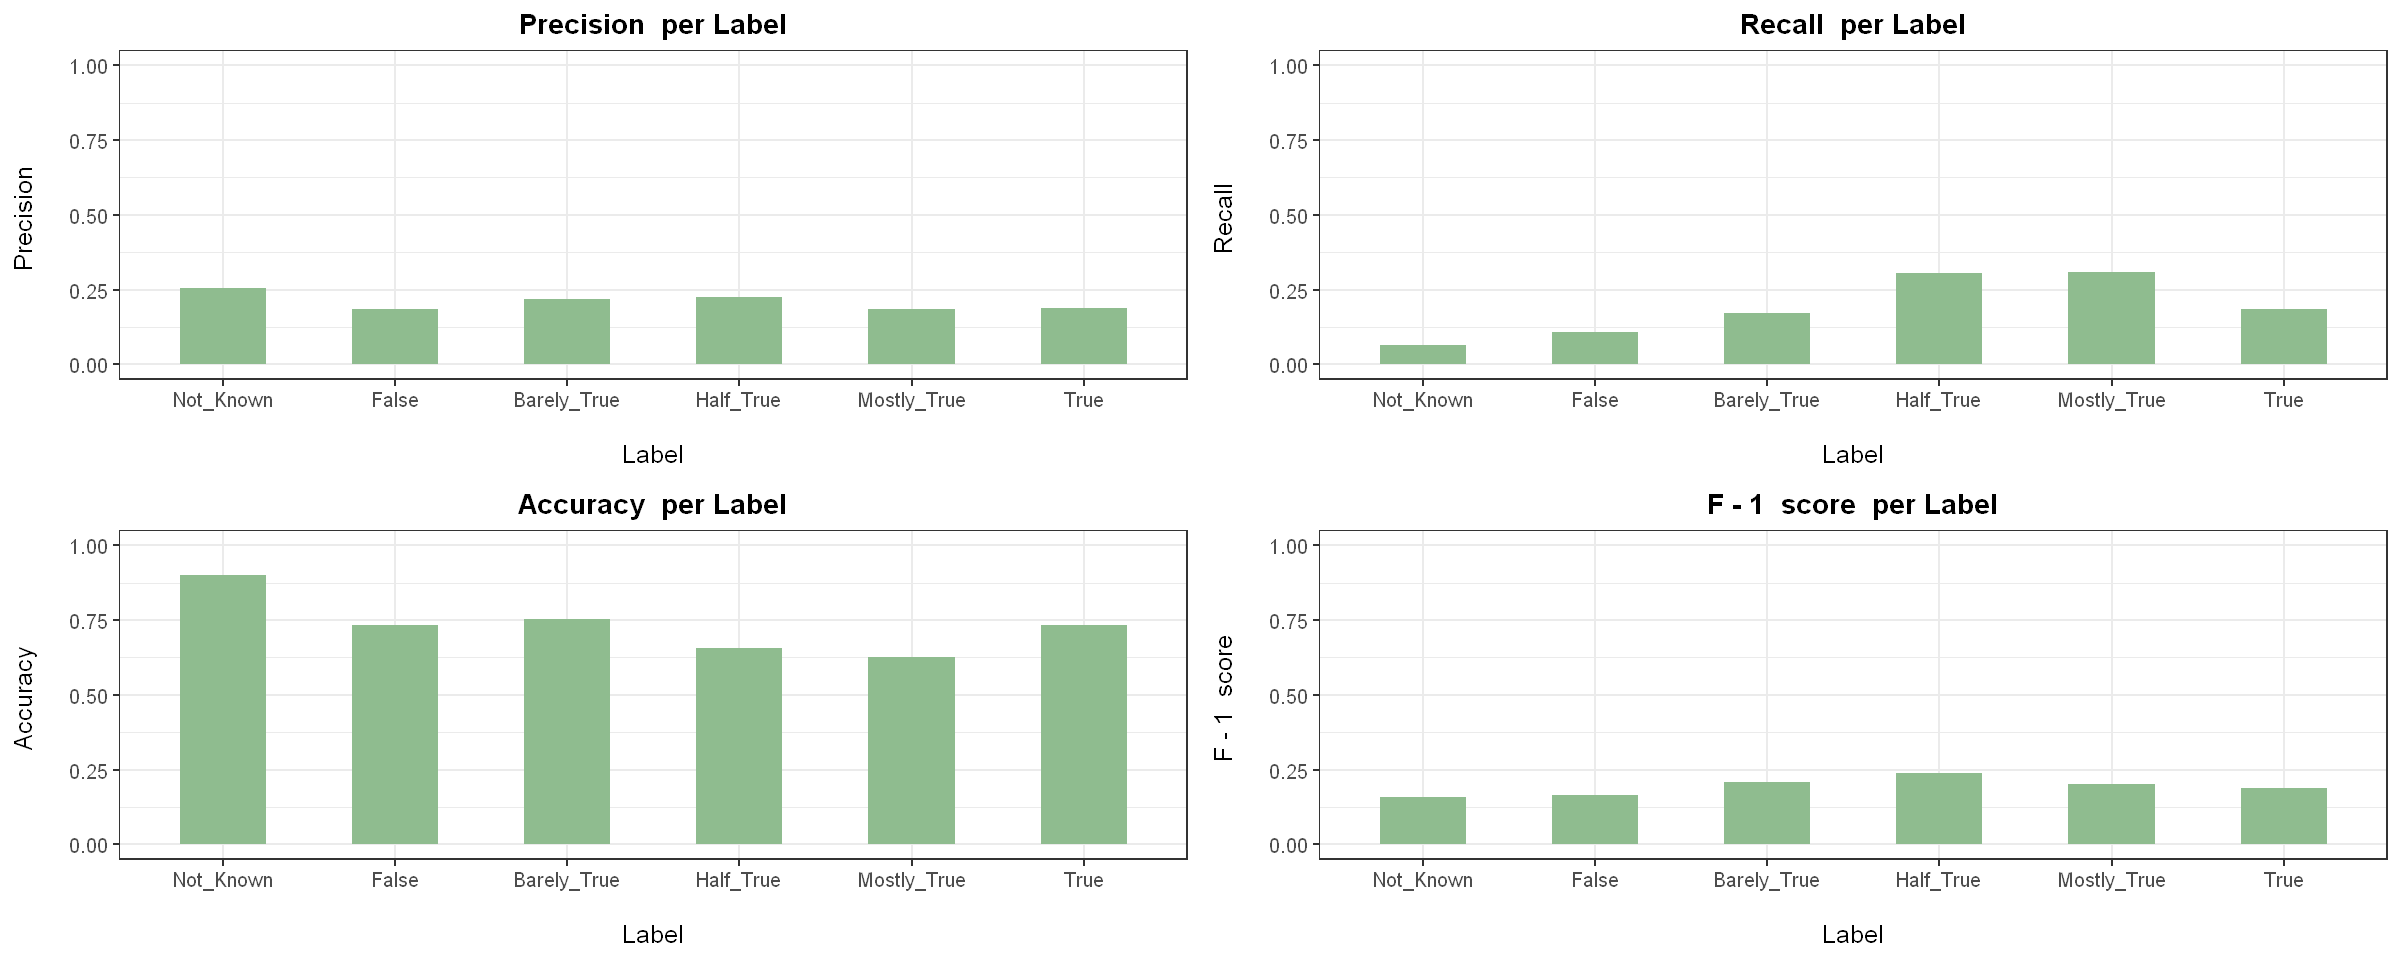

In [108]:
options(repr.plot.width = 20, repr.plot.height = 8)

beta_val = 1

accuracy_plot <- plot_bar(tb_metrics, 'acc', 'Accuracy')
precision_plot <- plot_bar(tb_metrics, 'precision', 'Precision')
recall_plot <- plot_bar(tb_metrics, 'recall', 'Recall')
fbeta_plot <- plot_bar(tb_metrics, 'f_beta', paste('F -', beta_val, ' score'))

grid.arrange(precision_plot, recall_plot,
                accuracy_plot, fbeta_plot,
                nrow=2, ncol=2,
                padding = unit(5, 'cm'))

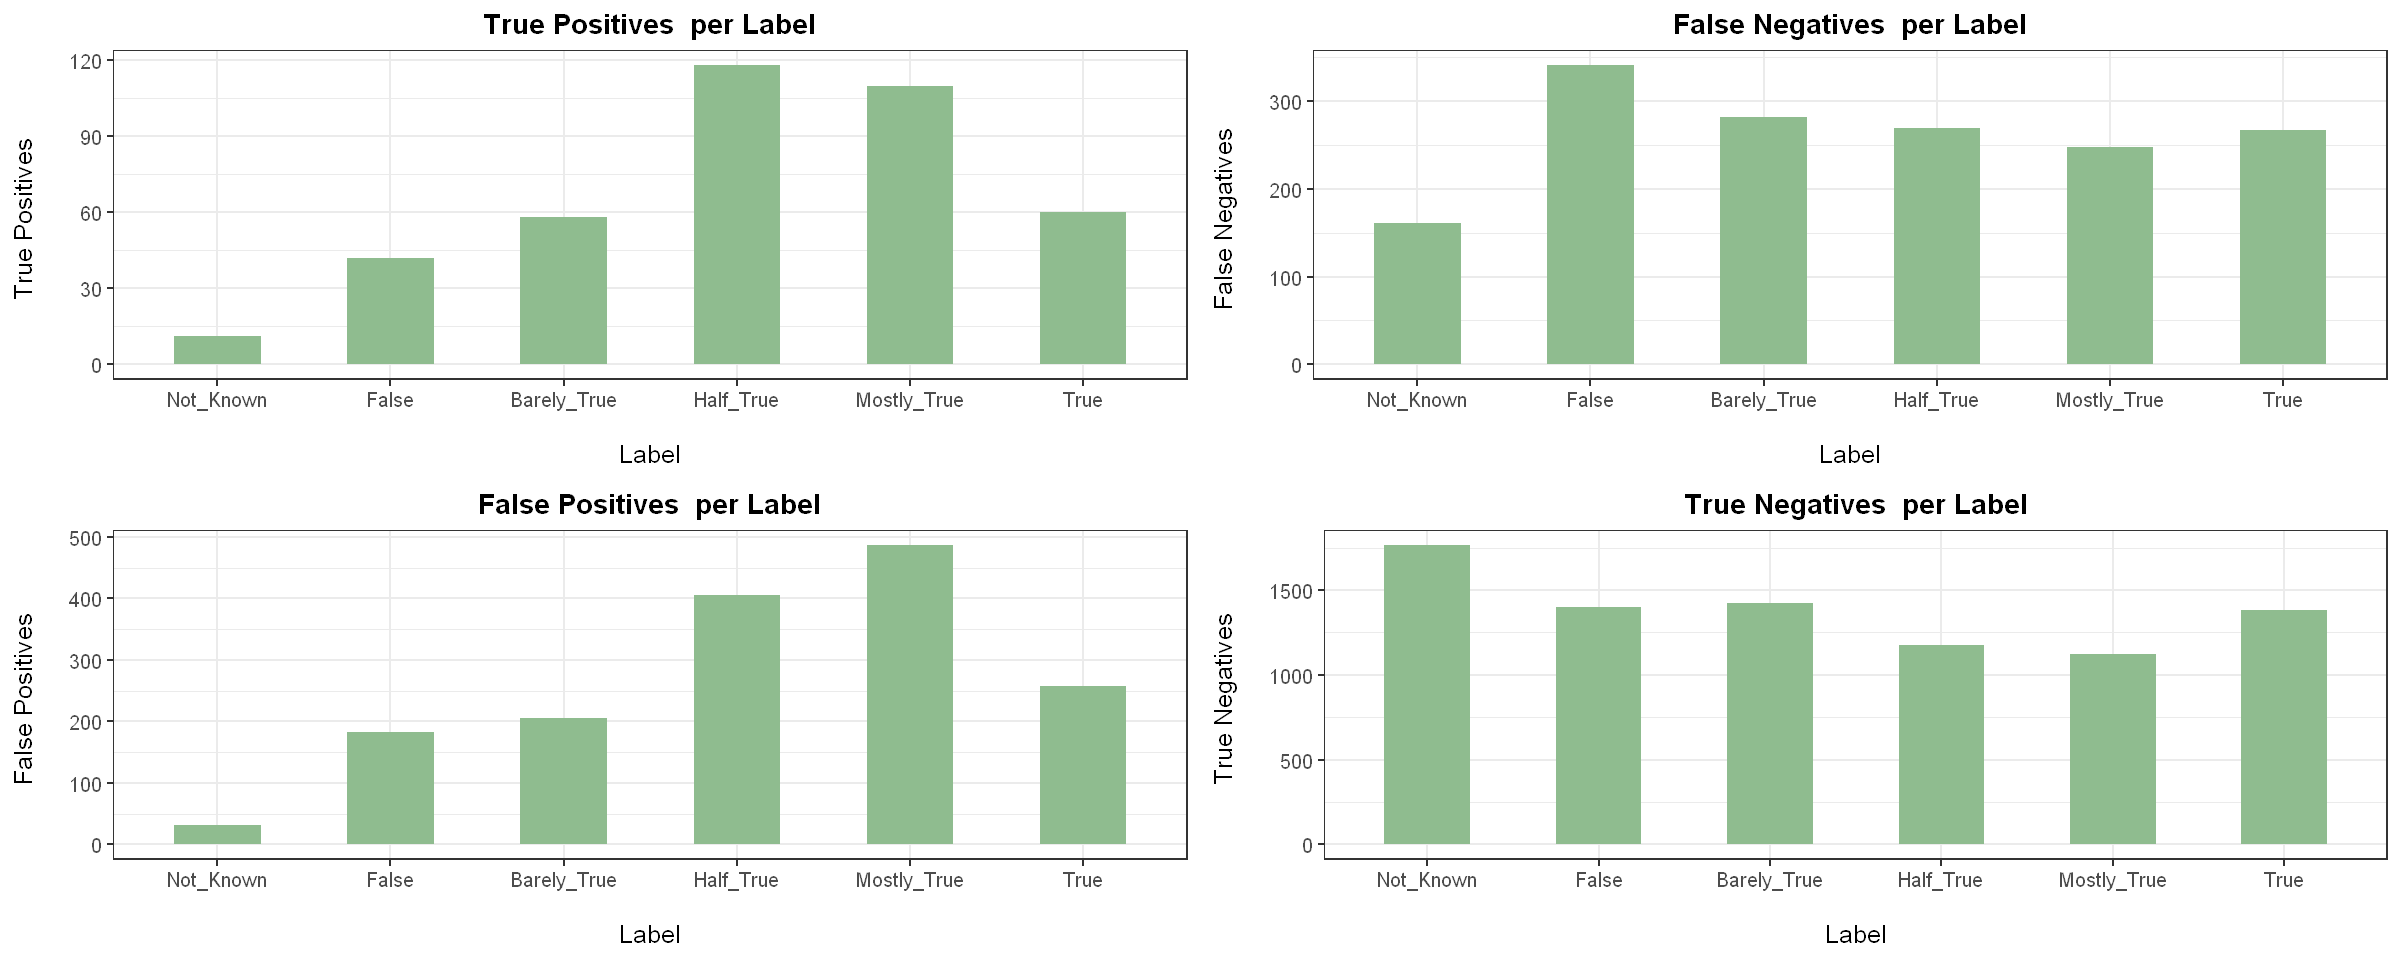

In [109]:
tp_plot <- plot_bar(tb_metrics, 'tp', paste('True Positives'))
fn_plot <- plot_bar(tb_metrics, 'fn', paste('False Negatives'))
fp_plot <- plot_bar(tb_metrics, 'fp', paste('False Positives'))
tn_plot <- plot_bar(tb_metrics, 'tn', paste('True Negatives'))

grid.arrange(tp_plot, fn_plot,
                fp_plot, tn_plot,
                nrow=2, ncol=2,
                padding = unit(5, 'cm'))

##### Heatmap : Full Labels

In [113]:
plot_heatmap <- function(tb_compare, labels_descrip, normalize, plot_title='Heatmap', legend_title='Counts'){
    
        tb_ref <- tibble(True_Label = rep(labels_descrip$Labels, times = nrow(labels_descrip)), 
                        Pred_Label= rep(labels_descrip$Labels, each = nrow(labels_descrip)),
                        True_Name = rep(labels_descrip$Name, times = nrow(labels_descrip)),
                        Pred_Name= rep(labels_descrip$Name, each = nrow(labels_descrip)))

        tb_counts <- tb_compare %>% 
                        group_by(across(all_of(c('True_Label', 'Pred_Label')))) %>%
                        summarise(n = n())

        tb_grid <- tb_ref %>% 
                        left_join(tb_counts, by=c('True_Label', 'Pred_Label')) %>%
                        replace_na(list(n = 0)) %>%
                        mutate(n_norm = round(n / sum(n), 3))

        norm_str <- ifelse(normalize, 'n_norm', 'n')
        main <- ggplot(tb_grid, aes(Pred_Name, True_Name, fill=!!sym(norm_str))) +
                        geom_tile() +
                        geom_text(aes(label=!!sym(norm_str)), size = 5, color = 'white') +
                        theme_minimal() +

                        #scale_fill_gradient(low='indianred3', high='royalblue1') +
                        #scale_fill_gradient(low='lightsalmon3', high='royalblue1') +
                        scale_fill_viridis(option='E') +
                        #scale_fill_distiller(palette = 'RdBu', direction = 1) +

                        theme(plot.title = element_text(hjust = 0, face='bold', size=17),
                                legend.title = element_text(face='bold', margin = margin(b = 10, unit='pt')),
                                axis.title = element_text(face='bold', size=14),
                                axis.title.x = element_text(margin = margin(t = 20, unit = "pt")),
                                axis.title.y = element_text(margin = margin(r = 20, unit = "pt")),
                                axis.text = element_text(face="bold", size=12) ) +

                        labs(title = plot_title,
                                x = '\nPredicted Label',
                                y = 'Actual Label\n',
                                fill = legend_title) +
                        
                        scale_x_discrete(limits = c('True', 'Mostly_True', 'Half_True', 'Barely_True', 'False', 'Not_Known'))
                        #scale_x_discrete(limits = c('Unreliable', 'Reliable'))

        return(main)
}

`summarise()` has grouped output by 'True_Label'. You can override using the
`.groups` argument.


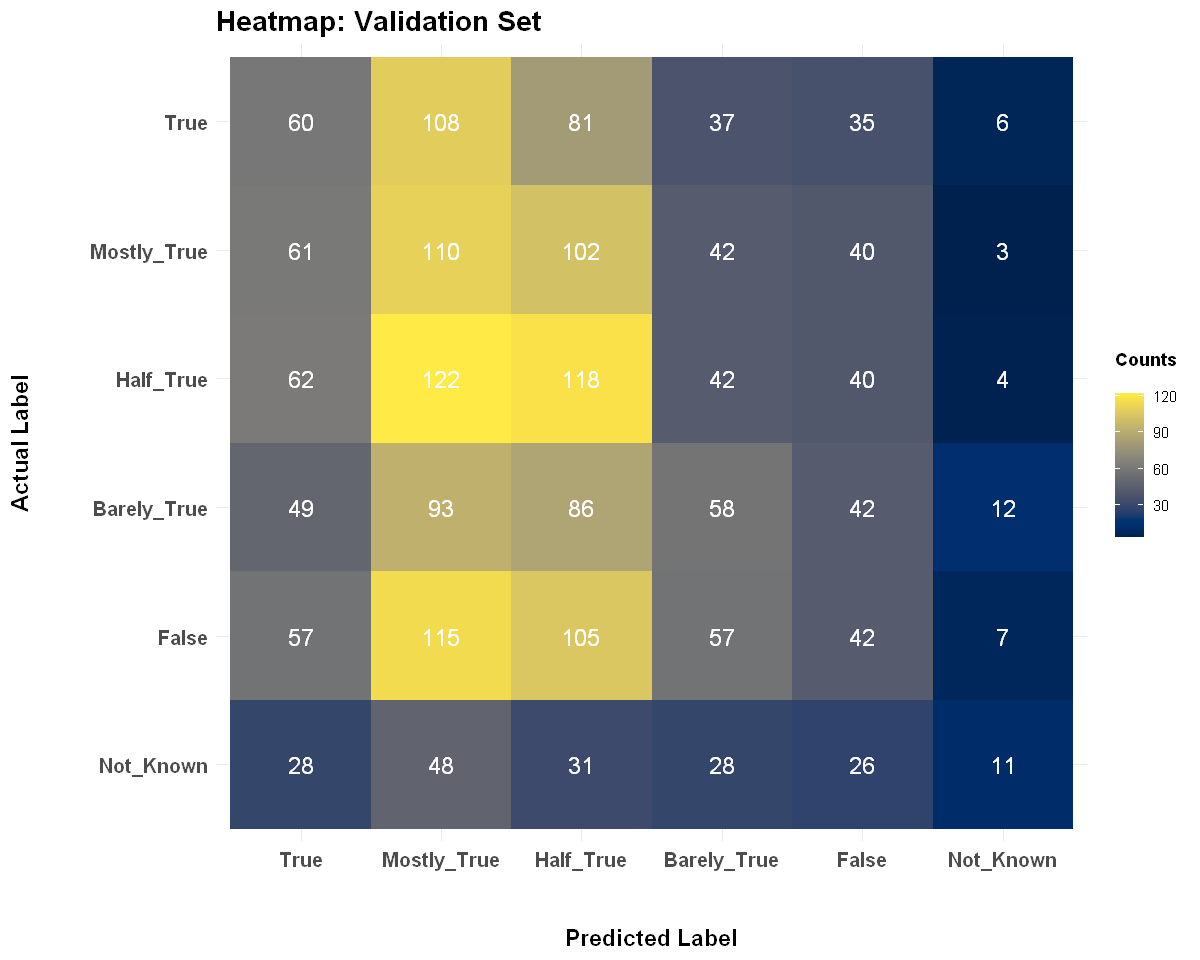

In [114]:
options(repr.plot.width=10, repr.plot.height=8)

plot_heatmap(tb_valid_compare, labels_descrip, 
                normalize = FALSE,
                plot_title = 'Heatmap: Validation Set',
                legend_title = 'Counts')

`summarise()` has grouped output by 'True_Label'. You can override using the
`.groups` argument.


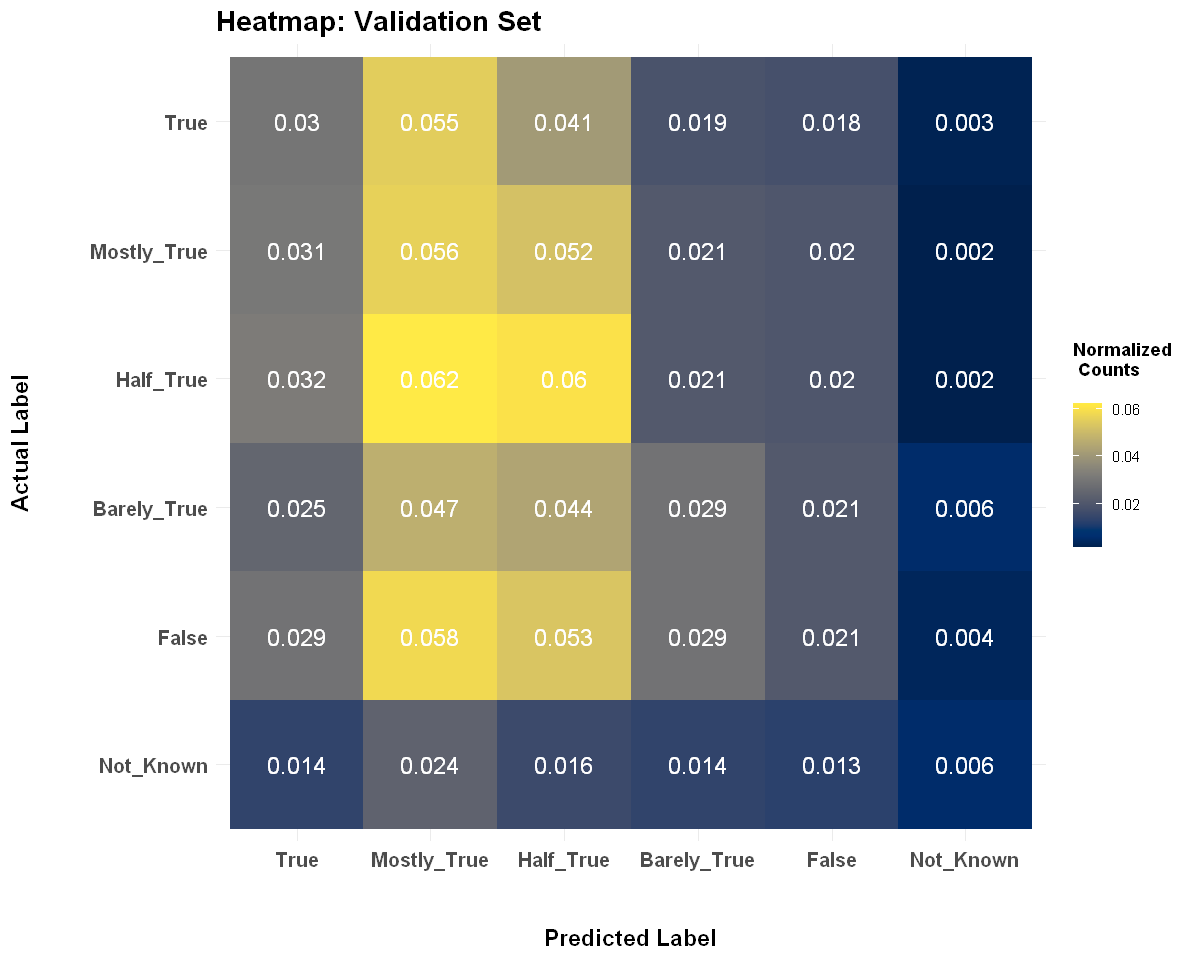

In [115]:
options(repr.plot.width=10, repr.plot.height=8)

plot_heatmap(tb_valid_compare, labels_descrip, 
                normalize = TRUE,
                plot_title = 'Heatmap: Validation Set',
                legend_title = 'Normalized \n Counts')

## Running all for both Datasets

In [116]:
#For Both Datasets
train_validate_model <- function(df_train_valid, labels_descrip, 
                                    dataset_num = 2,
                                    split_perc = 0.8,               #Split percentage of train and valid sets
                                    stem = TRUE,                    #Implement Stemming
                                    lem = FALSE,                    #Implement Lemmatization
                                    feature_selection = TRUE,       #If feature selection should be implmented
                                    top_k = 1000,                   #Top k features to be selected
                                    laplace_factor = 1,             #Laplace smoothing factor
                                    keep_ties = FALSE,              #Keep ties for feature selection, prediction
                                    remove_perc = 0.5,              #Remove document with high number of new words
                                    fbeta_val = 1){                 #F_Beta value to be used for metric

    #Splitting the Data
    set.seed(100)

    #Shuffles and splits the data by percentage
    split_bool <- sample.split(df_train_valid$Text, SplitRatio = split_perc)    
    df_train <- subset(df_train_valid, split_bool == TRUE)
    df_valid <- subset(df_train_valid, split_bool == FALSE)

    #print('Finished Splitting...')

    tb_train <- prepare_tibble(df_train, dataset_num=dataset_num, factor_labels = TRUE, remove_tag = ifelse(dataset_num == 1, TRUE, FALSE))
    tb_valid <- prepare_tibble(df_valid, dataset_num=dataset_num, factor_labels = TRUE, remove_tag = ifelse(dataset_num == 1, TRUE, FALSE))

    #print('Finished Preparing Tibble...')

    #Cleaning Data and getting vocabulary
    tb_train_clean <- clean_tibble(tb_train, stem=stem, lem=lem)
    vocab <- unique(tb_train_clean$word)

    #print('Finished Tokenizing...')

    # Feature Selection
    if (feature_selection){
        
        tb_features <- implement_feature_selection(tb_train, tb_train_clean, vocab, 
                                                    top_k = top_k, 
                                                    laplace_factor = laplace_factor,
                                                    keep_ties = keep_ties)


        tb_train_clean_reduced <- tb_train_clean %>% inner_join(tb_features, by=c('Labels', 'word'))

        #print('Finished Feature Selection...')

        # Building and Training Model
        mnb_model <- build_mnb_model(tb_train, tb_train_clean_reduced, laplace_factor = laplace_factor)
    }
    #No feature selection
    else {  
        # Building and Training Model
        mnb_model <- build_mnb_model(tb_train, tb_train_clean, laplace_factor = laplace_factor)
    }
    
    tb_priors <- mnb_model$prior
    tb_cond <- mnb_model$cond
    vocab <- mnb_model$vocab

    #print('Finished Training Model...')

    #Validating Model
    tb_valid_preds <- predict_labels(tb_valid, tb_priors, tb_cond, 
                                        remove_perc = remove_perc, 
                                        keep_ties = keep_ties )
    
    #print('Finished Predicting...')

    tb_valid_compare <- tb_valid %>%

                            #Removes Text column, gets distinct rows
                            select(document_id, Labels) %>%

                            #Joins prediction tibble for comparison
                            right_join(tb_valid_preds, by='document_id', multiple='all') %>%
                            select(document_id, True_Label = Labels.x, Pred_Label = Labels.y)

    
    #Get metrics
    tb_metrics <- get_metrics(tb_valid_compare, labels_descrip, beta_val=fbeta_val)   

    #Add param values to tb_metrics
    tb_param_metrics <- tibble(stem = rep(stem, nrow(tb_metrics)),
                                lem = rep(lem, nrow(tb_metrics)),
                                feat = rep(feature_selection, nrow(tb_metrics)), 
                                top_k = rep(top_k, nrow(tb_metrics)), 
                                keep_ties = rep(keep_ties, nrow(tb_metrics)),
                                remove_perc = rep(remove_perc, nrow(tb_metrics))) %>%

                                        #Add tb_metrics
                                        add_column(tb_metrics) 

    #Add prior values to tb_param_metrics
    tb_param_metrics <- tb_param_metrics %>% left_join(tb_priors, by='Labels')

    #print('Finished Getting Metrics...')

    return (list(metrics = tb_param_metrics, priors = tb_priors, conds = tb_cond, vocab = vocab))

}

#### For First Dataset

In [53]:
#First Dataset: Loading the data
df_train_valid <- read.csv('archive/train.csv')  
df_test <- read.csv('archive/test.csv')

reorder_labels <- c(4, 1, 0, 2, 3, 5)

labels <- factor(0:5, levels = reorder_labels)
names <- c('Barely_True', 'False', 'Half_True', 'Mostly_True', 'Not_Known', 'True')

labels_descrip <- tibble(Labels = labels, Name = factor(names, levels = names[reorder_labels + 1]))

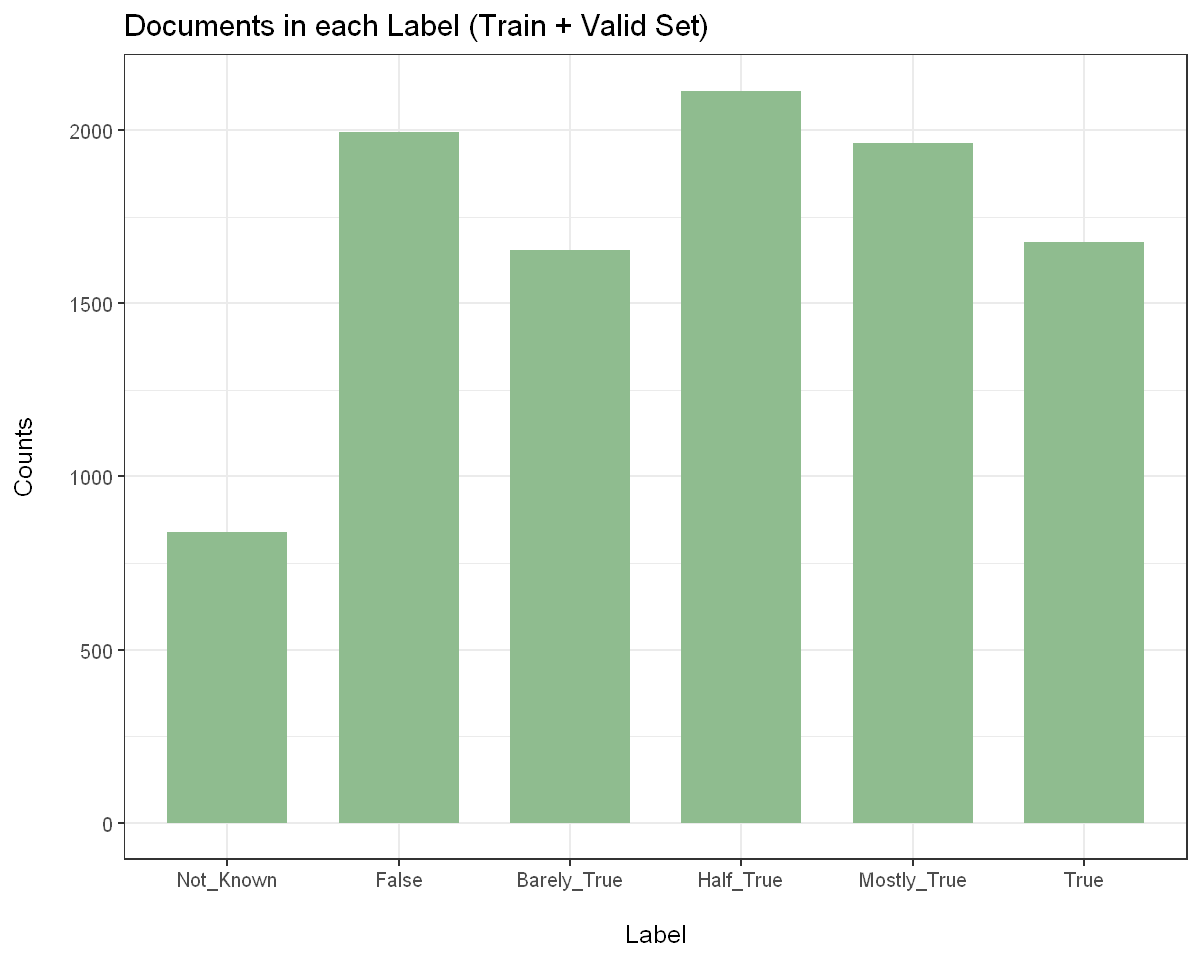

In [54]:
label_counts <- df_train_valid %>%
                    group_by(Labels) %>%
                    summarise(counts = n()) %>%
                    mutate(Labels = factor(Labels, levels = reorder_labels)) %>%
                    left_join(labels_descrip, by='Labels')

ggplot(label_counts, aes(x = Name, y = counts)) +
            theme_bw(base_size = 15) +
            geom_bar(stat = 'identity', fill='darkseagreen', width=0.7) +
            ggtitle('Documents in each Label (Train + Valid Set)') +
            xlab('\nLabel') +
            ylab('Counts\n')

In [57]:
run_count <- 0
metric_list <- list()

feat_values <- c(TRUE)
stem_values <- c(TRUE, FALSE)
ties_values <- c(TRUE, FALSE)
remperc_values <- c(0.25, 0.5, 0.75)

#top_k_values <- c(10, 100, 500, 750, 1000, 1700, 2500, 3750, 5000, 6250, 7000, 7500, 8750, 9500, 10000)
#top_k_values <- c(10, 100, 500, 1000, 2500, 5000, 10000)
#top_k_values <- c(10, 100, 500, 1000, 5000, 10000)
top_k_values <- c(500)

param_list <- tibble(feat = rep(feat_values, each=length(top_k_values)), 
                        #perc = rep(remperc_values, each=length(top_k_values)),
                        #stem = rep(stem_values, each=length(top_k_values)),
                        #ties = rep(ties_values, each=length(top_k_values)),
                        top_k = rep(top_k_values, times=length(feat_values)))


for (i in 1:dim(param_list)[1]){

    run_count <- run_count + 1
    message(paste('\nStarted run : ', run_count))

    suppressMessages({

        model_results <- train_validate_model(df_train_valid, labels_descrip,
                                                dataset_num = 1,
                                                split_perc = 0.8,
                                                stem = TRUE,
                                                lem = FALSE,
                                                feature_selection = param_list[i, ]$feat,
                                                top_k = param_list[i, ]$top_k,                                                
                                                laplace_factor = 1,
                                                keep_ties = FALSE,
                                                remove_perc = 0.75,
                                                fbeta_val = 1)

    })

    metric_list <- c(list(model_results$metrics), metric_list)
    if (run_count == 1){ tb_joined <- model_results$metrics }
    else { tb_joined <- tb_joined %>% add_row(model_results$metrics)}

}


Started run :  1



In [108]:
#Group by changing parameters, and get micro, macro metric values
tb_reduced <- tb_joined %>% 
                group_by(across(all_of(c('remove_perc', 'top_k')))) %>%
                summarise(micro_acc = mean(total_acc), 
                            macro_weigh_acc = sum(acc * prior) / n(),
                            macro_weigh_precision = sum(precision * prior) / n(),
                            macro_weigh_recall = sum(recall * prior) / n(),
                            macro_weigh_fbeta = sum(f_beta * prior) / n(),
                            macro_acc = mean(acc),
                            macro_fbeta = mean(f_beta))

head(tb_reduced, 3)

`summarise()` has grouped output by 'remove_perc'. You can override using the
`.groups` argument.


remove_perc,top_k,micro_acc,macro_weigh_acc,macro_weigh_precision,macro_weigh_recall,macro_weigh_fbeta,macro_acc,macro_fbeta
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.25,10,0.2352941,0.1241112,NaN,0.04288364,0.03524701,0.7450980,0.2075264
0.25,100,0.1864686,0.1178379,0.03259344,0.03172340,0.03050952,0.7288229,0.1766200
0.25,500,0.2064808,0.1188873,0.03728377,0.03529609,0.03290667,0.7354936,0.1874906


In [110]:
tb_reduced <- tb_reduced %>%
                mutate(remove_perc = as.factor(remove_perc))

In [ ]:
options(repr.plot.height=8, repr.plot.width=13)

#Line Plot for comparison between parameter evolutions( Eg.: Number of Features vs Mico Accuracy)
ggplot(tb_reduced, aes(x=top_k, y=macro_fbeta, col=remove_perc, fill=remove_perc)) +
        geom_line(size = 1) +
        geom_point(size = 2.5, color='black') +
        theme_bw(base_size = 15) +
        
        theme(plot.title = element_text(hjust = 0.5, face='bold', size=19),
                plot.subtitle = element_text(hjust = 0.5, size=15),
                legend.title = element_text(face='bold'),
                axis.title = element_text(face='bold')) +

        labs(x = '\nNumber of Features', 
                y = 'Marco - F-1 Score\n',
                title = '\nMarco - F-1 Score vs Number of Features\n',
                #subtitle = 'Comparison',
                fill = 'Feature Selection',
                col = 'Feature Selection'
                )

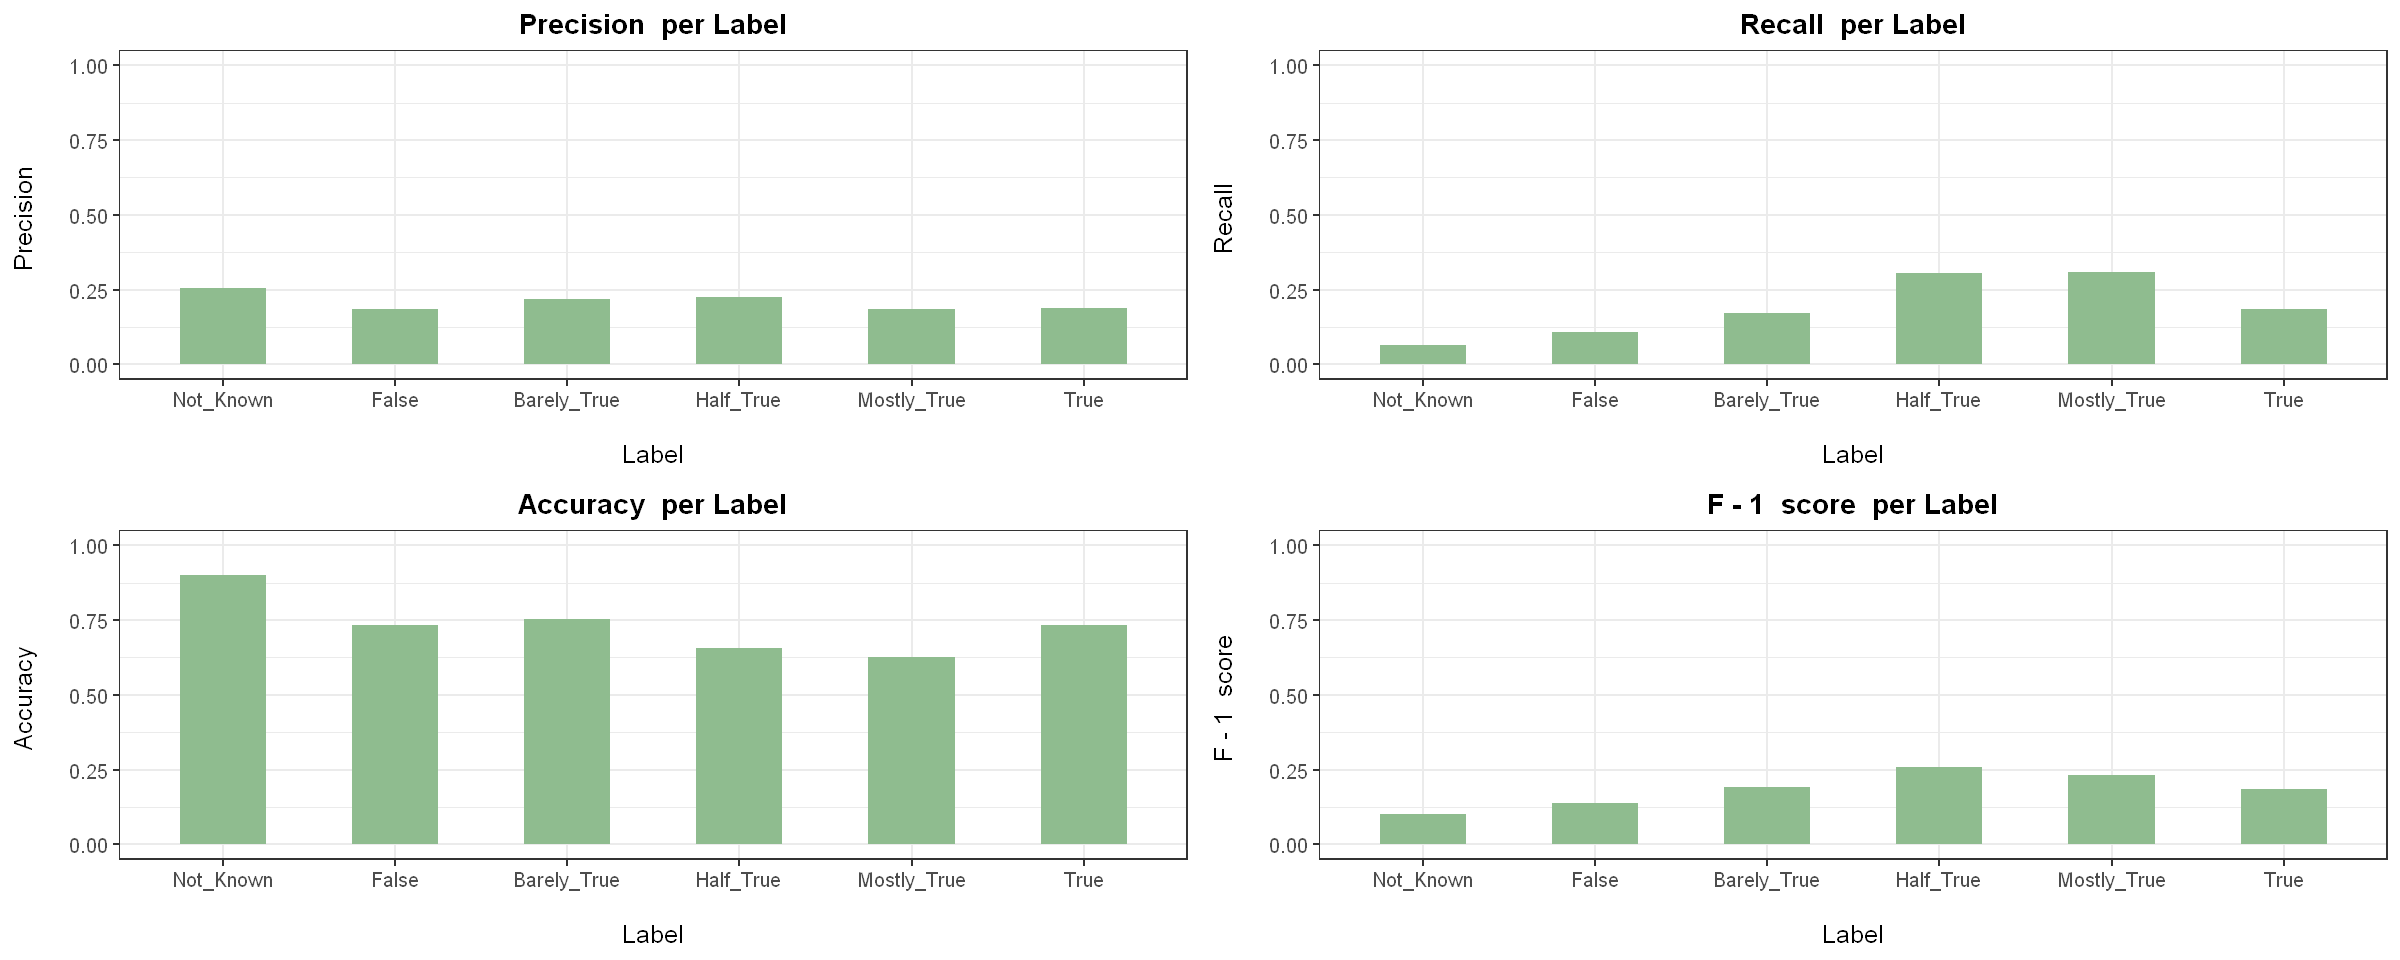

In [58]:
options(repr.plot.width = 20, repr.plot.height = 8)

fbeta_val <- 1

#Plot Bar plots of metric values for each label
for (tb in metric_list){

    accuracy_plot <- plot_bar(tb, 'acc', 'Accuracy')
    precision_plot <- plot_bar(tb, 'precision', 'Precision')
    recall_plot <- plot_bar(tb, 'recall', 'Recall')
    fbeta_plot <- plot_bar(tb, 'f_beta', paste('F -', fbeta_val, ' score'))

    grid.arrange(precision_plot, recall_plot,
                    accuracy_plot, fbeta_plot,
                    nrow=2, ncol=2,
                    padding = unit(5, 'cm'))

}



##### Testing Model

#### For Second Dataset

In [14]:
#Second Dataset: Loading the Data
df_train_valid <- read.csv('E:/new_dataset/train.csv')
df_test <- read.csv('E:/new_dataset/test.csv')

df_train_valid <- df_train_valid %>% select(document_id = id, Labels = label, Text = text)
df_test <- df_test %>% select(document_id = id, Text = text)

reorder_labels <- c(0, 1)
labels <- factor(c(0, 1), levels = reorder_labels)
names <- c('Reliable', 'Unreliable')

labels_descrip <- tibble(Labels = labels, Name = factor(names, levels = names[reorder_labels + 1]))

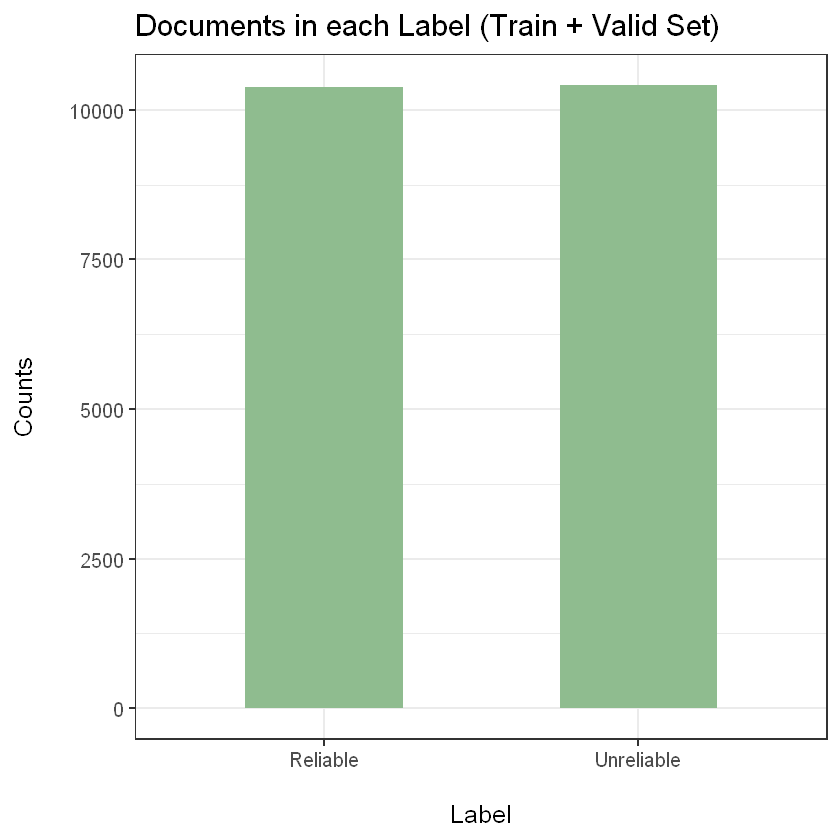

In [15]:
label_counts <- df_train_valid %>%
                    group_by(Labels) %>%
                    summarise(counts = n()) %>%
                    mutate(Labels = factor(Labels, levels = reorder_labels)) %>%
                    left_join(labels_descrip, by='Labels')

ggplot(label_counts, aes(x = Name, y = counts)) +
            theme_bw(base_size = 15) +
            geom_bar(stat = 'identity', fill='darkseagreen', width=0.5) +
            ggtitle('Documents in each Label (Train + Valid Set)') +
            xlab('\nLabel') +
            ylab('Counts\n')

In [19]:
run_count <- 0
metric_list <- list()

feat_values <- c(TRUE)
stem_values <- c(TRUE, FALSE)
ties_values <- c(TRUE, FALSE)
remperc_values <- c(0.25, 0.5, 0.75)

#top_k_values <- c(10, 100, 500, 750, 1000, 1700, 2500, 3750, 5000, 6250, 7000, 7500, 8750, 9500, 10000)
#top_k_values <- c(10, 100, 500, 1000, 2500, 5000, 10000, 15000, 20000)
#top_k_values <- c(1000, 10000, 20000, 35000, 50000, 70000, 100000, 250000, 500000)
top_k_values <- c(20000)

param_list <- tibble(feat = rep(feat_values, each=length(top_k_values)), 
                        #perc = rep(remperc_values, each=length(top_k_values)),
                        #stem = rep(stem_values, each=length(top_k_values)),
                        #ties = rep(ties_values, each=length(top_k_values)),
                        top_k = rep(top_k_values, times=length(feat_values)))

for (i in 1:dim(param_list)[1]){

    run_count <- run_count + 1
    message(paste('\nStarted run : ', run_count))

    suppressMessages({

        model_results <- train_validate_model(df_train_valid, labels_descrip,
                                                dataset_num = 2,
                                                split_perc = 0.8,
                                                stem = TRUE,
                                                lem = FALSE,
                                                feature_selection = param_list[i, ]$feat,
                                                top_k = param_list[i, ]$top_k,
                                                laplace_factor = 1,
                                                keep_ties = FALSE,
                                                remove_perc = 0.75,
                                                fbeta_val = 1)

    })

    metric_list <- c(list(model_results$metrics), metric_list)
    if (run_count == 1){ tb_joined <- model_results$metrics }
    else { tb_joined <- tb_joined %>% add_row(model_results$metrics)}
}


Started run :  1



In [34]:
head(tb_joined)

stem,lem,feat,top_k,keep_ties,remove_perc,Labels,Name,tp,fp,fn,tn,total_acc,acc,precision,recall,f_beta,prior
<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,FALSE,TRUE,1000,FALSE,0.25,0,Reliable,2095,1652,2,374,0.5988358,0.5988358,0.5591140,0.9990463,0.7169747,0.4981971
TRUE,FALSE,TRUE,1000,FALSE,0.25,1,Unreliable,374,2,1652,2095,0.5988358,0.5988358,0.9946809,0.1846002,0.3114072,0.5018029
TRUE,FALSE,TRUE,10000,FALSE,0.25,0,Reliable,2096,1460,1,566,0.6456464,0.6456464,0.5894263,0.9995231,0.7415532,0.4981971
TRUE,FALSE,TRUE,10000,FALSE,0.25,1,Unreliable,566,1,1460,2096,0.6456464,0.6456464,0.9982363,0.2793682,0.4365600,0.5018029
TRUE,FALSE,TRUE,20000,FALSE,0.25,0,Reliable,2095,1398,2,628,0.6604414,0.6604414,0.5997710,0.9990463,0.7495528,0.4981971
TRUE,FALSE,TRUE,20000,FALSE,0.25,1,Unreliable,628,2,1398,2095,0.6604414,0.6604414,0.9968254,0.3099704,0.4728916,0.5018029


In [140]:
#Group by changing parameters, and get micro, macro metric values
tb_reduced <- tb_joined %>% 
                group_by(across(all_of(c('feat', 'top_k')))) %>%
                summarise(micro_acc = mean(total_acc), 
                            macro_weigh_acc = sum(acc * prior) / n(),
                            macro_weigh_precision = sum(precision * prior) / n(),
                            macro_weigh_recall = sum(recall * prior) / n(),
                            macro_weigh_fbeta = sum(f_beta * prior) / n(),
                            macro_acc = mean(acc),
                            macro_fbeta = mean(f_beta))

head(tb_reduced, 3)

`summarise()` has grouped output by 'feat'. You can override using the
`.groups` argument.


feat,top_k,micro_acc,macro_weigh_acc,macro_weigh_precision,macro_weigh_recall,macro_weigh_fbeta,macro_acc,macro_fbeta
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,20000,0.6860184,0.3430092,0.4041221,0.3401315,0.3239367,0.6860184,0.6482887
TRUE,20000,0.6606883,0.3303442,0.3998638,0.3269693,0.3056598,0.6606883,0.6118162


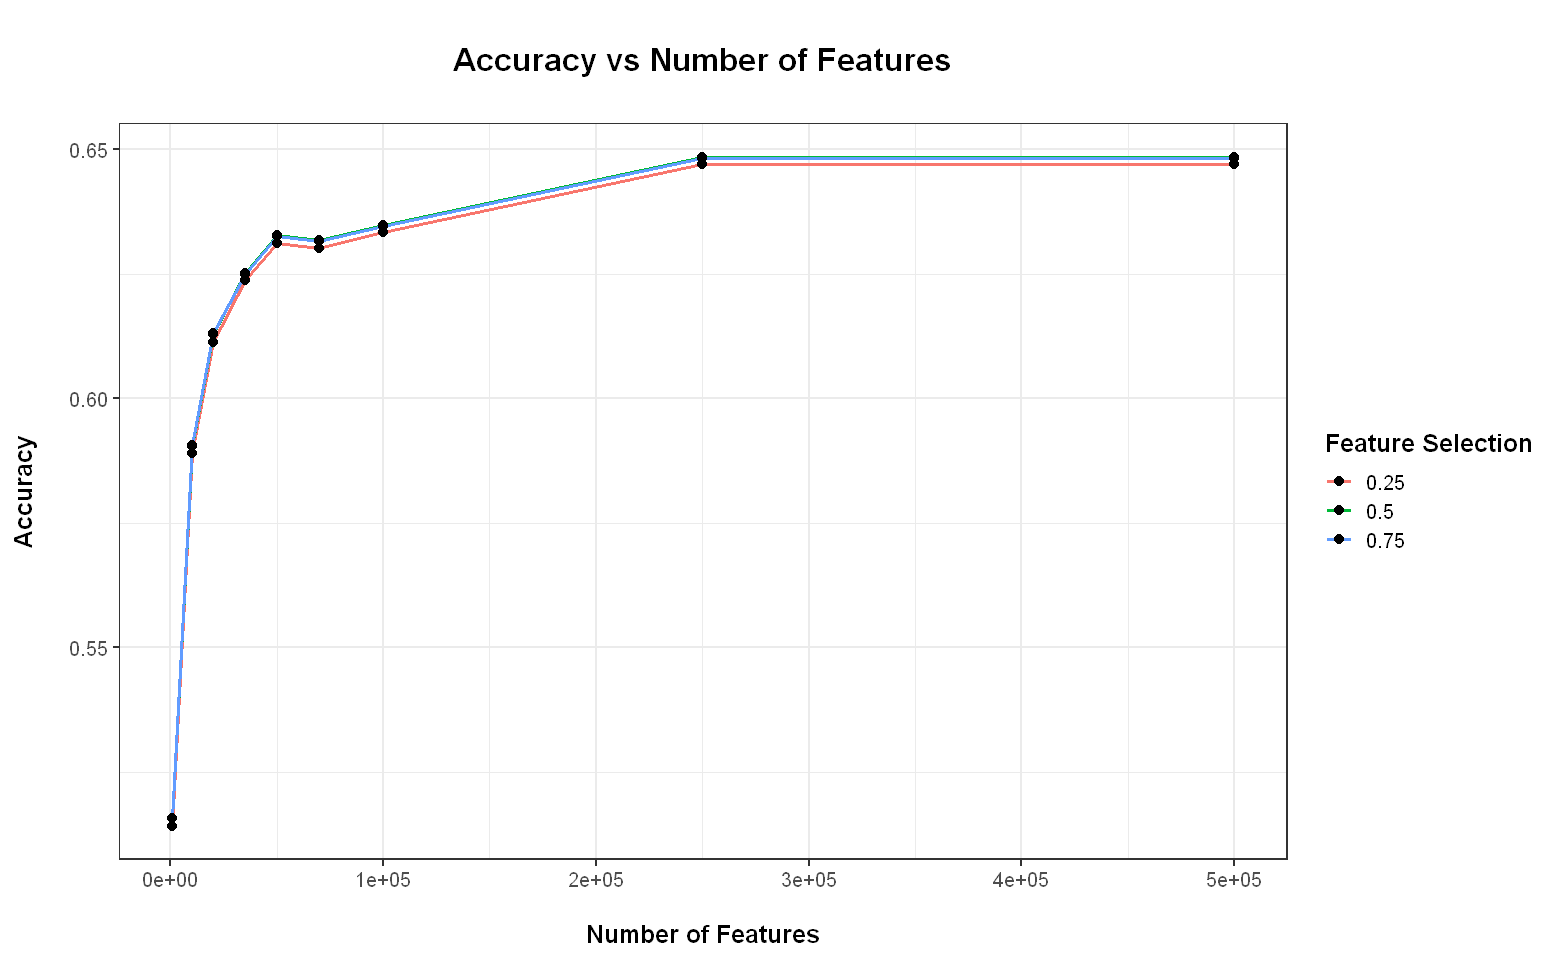

In [39]:
options(repr.plot.height=8, repr.plot.width=13)

#Line Plot for comparison between parameter evolutions( Eg.: Number of Features vs Mico Accuracy)
ggplot(tb_reduced, aes(x=top_k, y=macro_fbeta, col=remove_perc, fill=remove_perc)) +
        geom_line(size = 1) +
        geom_point(size = 2.5, color='black') +
        theme_bw(base_size = 15) +
        
        theme(plot.title = element_text(hjust = 0.5, face='bold', size=19),
                plot.subtitle = element_text(hjust = 0.5, size=15),
                legend.title = element_text(face='bold'),
                axis.title = element_text(face='bold')) +

        labs(x = '\nNumber of Features', 
                y = 'Accuracy\n',
                title = '\nAccuracy vs Number of Features\n',
                #subtitle = 'Comparison',
                fill = 'Feature Selection',
                col = 'Feature Selection'
                )

In [18]:
metric_list

stem,lem,feat,top_k,keep_ties,remove_perc,Labels,Name,tp,fp,fn,tn,total_acc,acc,precision,recall,f_beta,prior
<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,FALSE,FALSE,20000,FALSE,0.75,0,Reliable,2095,1296,2,741,0.6860184,0.6860184,0.6178119,0.9990463,0.7634840,0.4981971
TRUE,FALSE,FALSE,20000,FALSE,0.75,1,Unreliable,741,2,1296,2095,0.6860184,0.6860184,0.9973082,0.3637703,0.5330935,0.5018029
stem,lem,feat,top_k,keep_ties,remove_perc,Labels,Name,tp,fp,fn,tn,total_acc,acc,precision,recall,f_beta,prior
<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,FALSE,TRUE,20000,FALSE,0.75,0,Reliable,2095,1399,1,631,0.6606883,0.6606883,0.5995993,0.9995229,0.7495528,0.4981971
TRUE,FALSE,TRUE,20000,FALSE,0.75,1,Unreliable,631,1,1399,2095,0.6606883,0.6606883,0.9984177,0.3108374,0.4740796,0.5018029


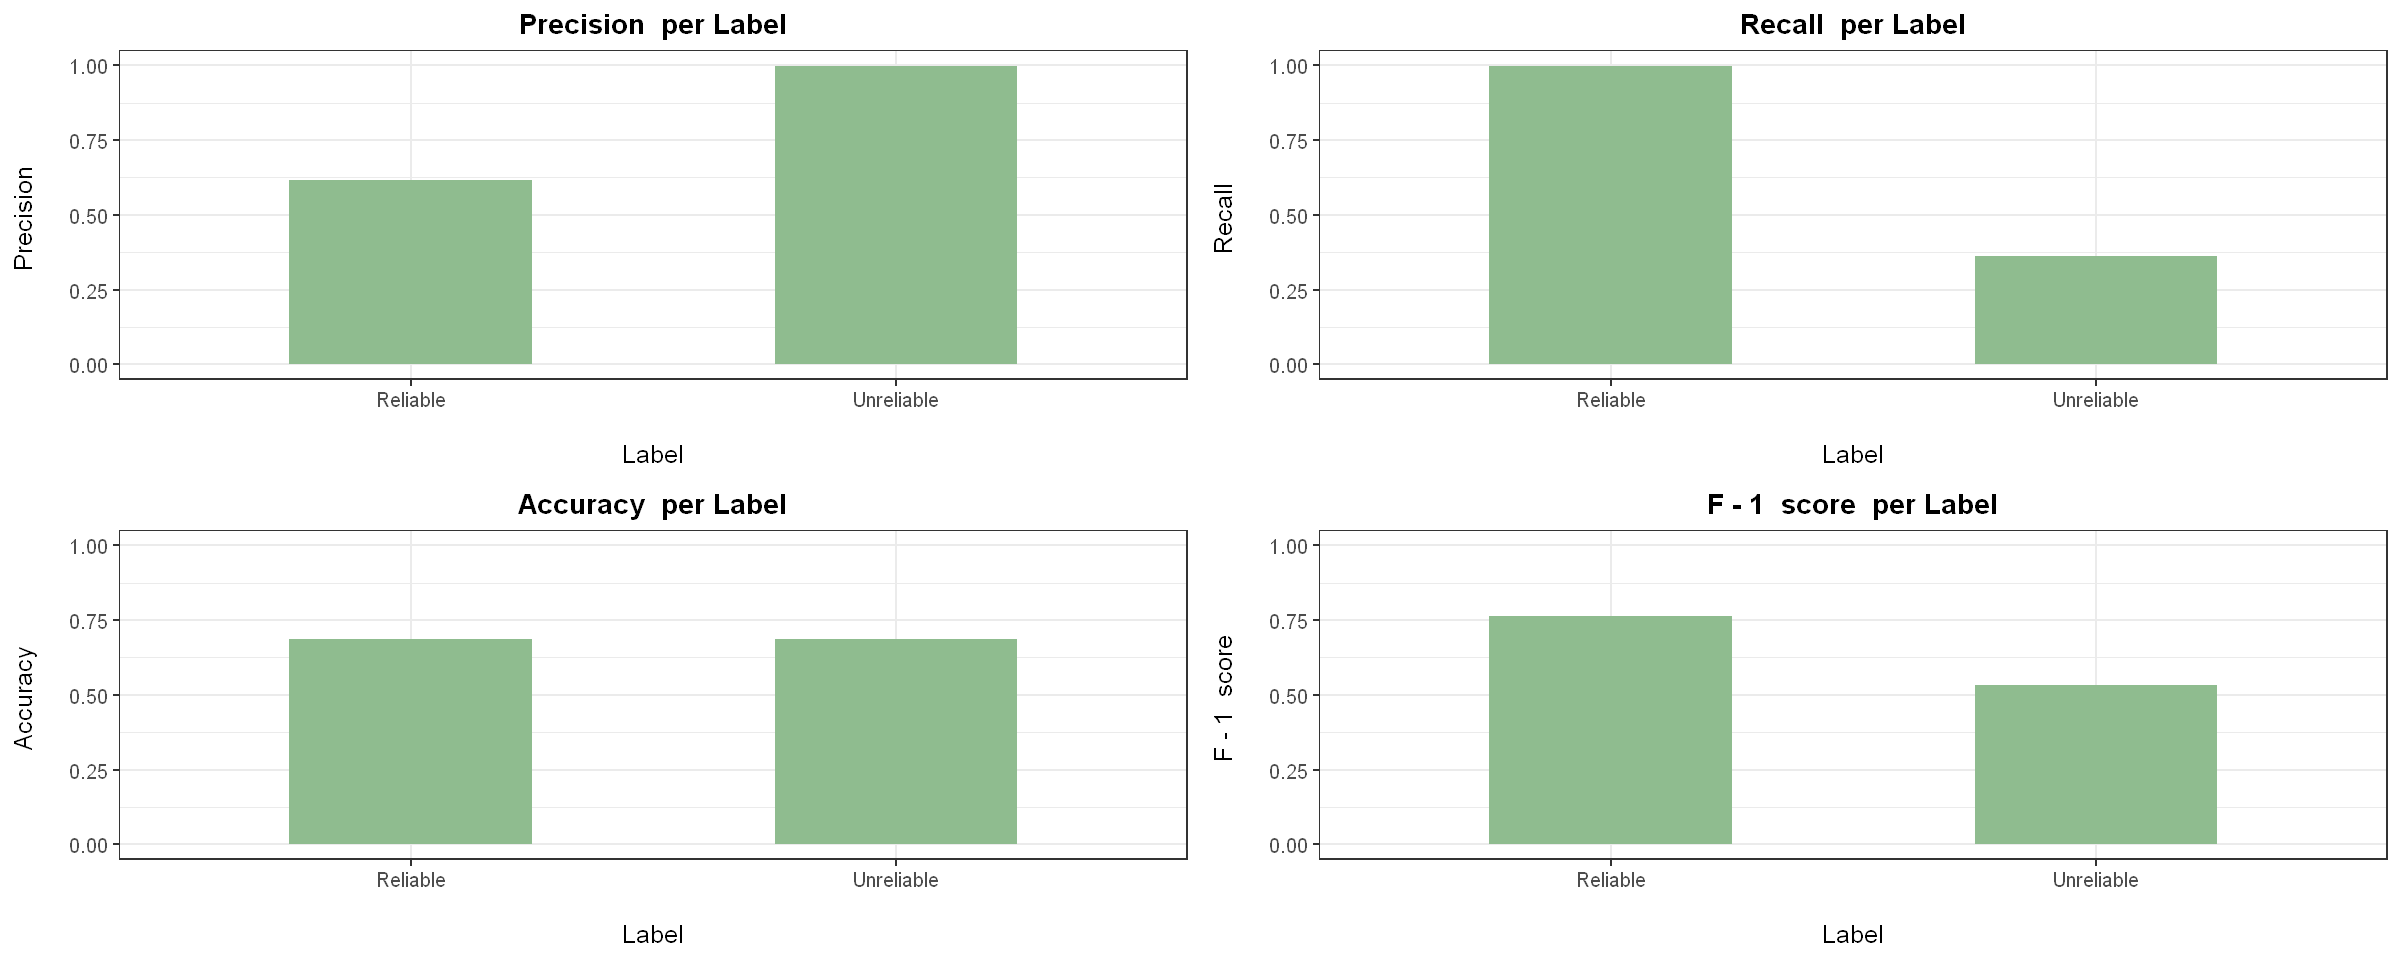

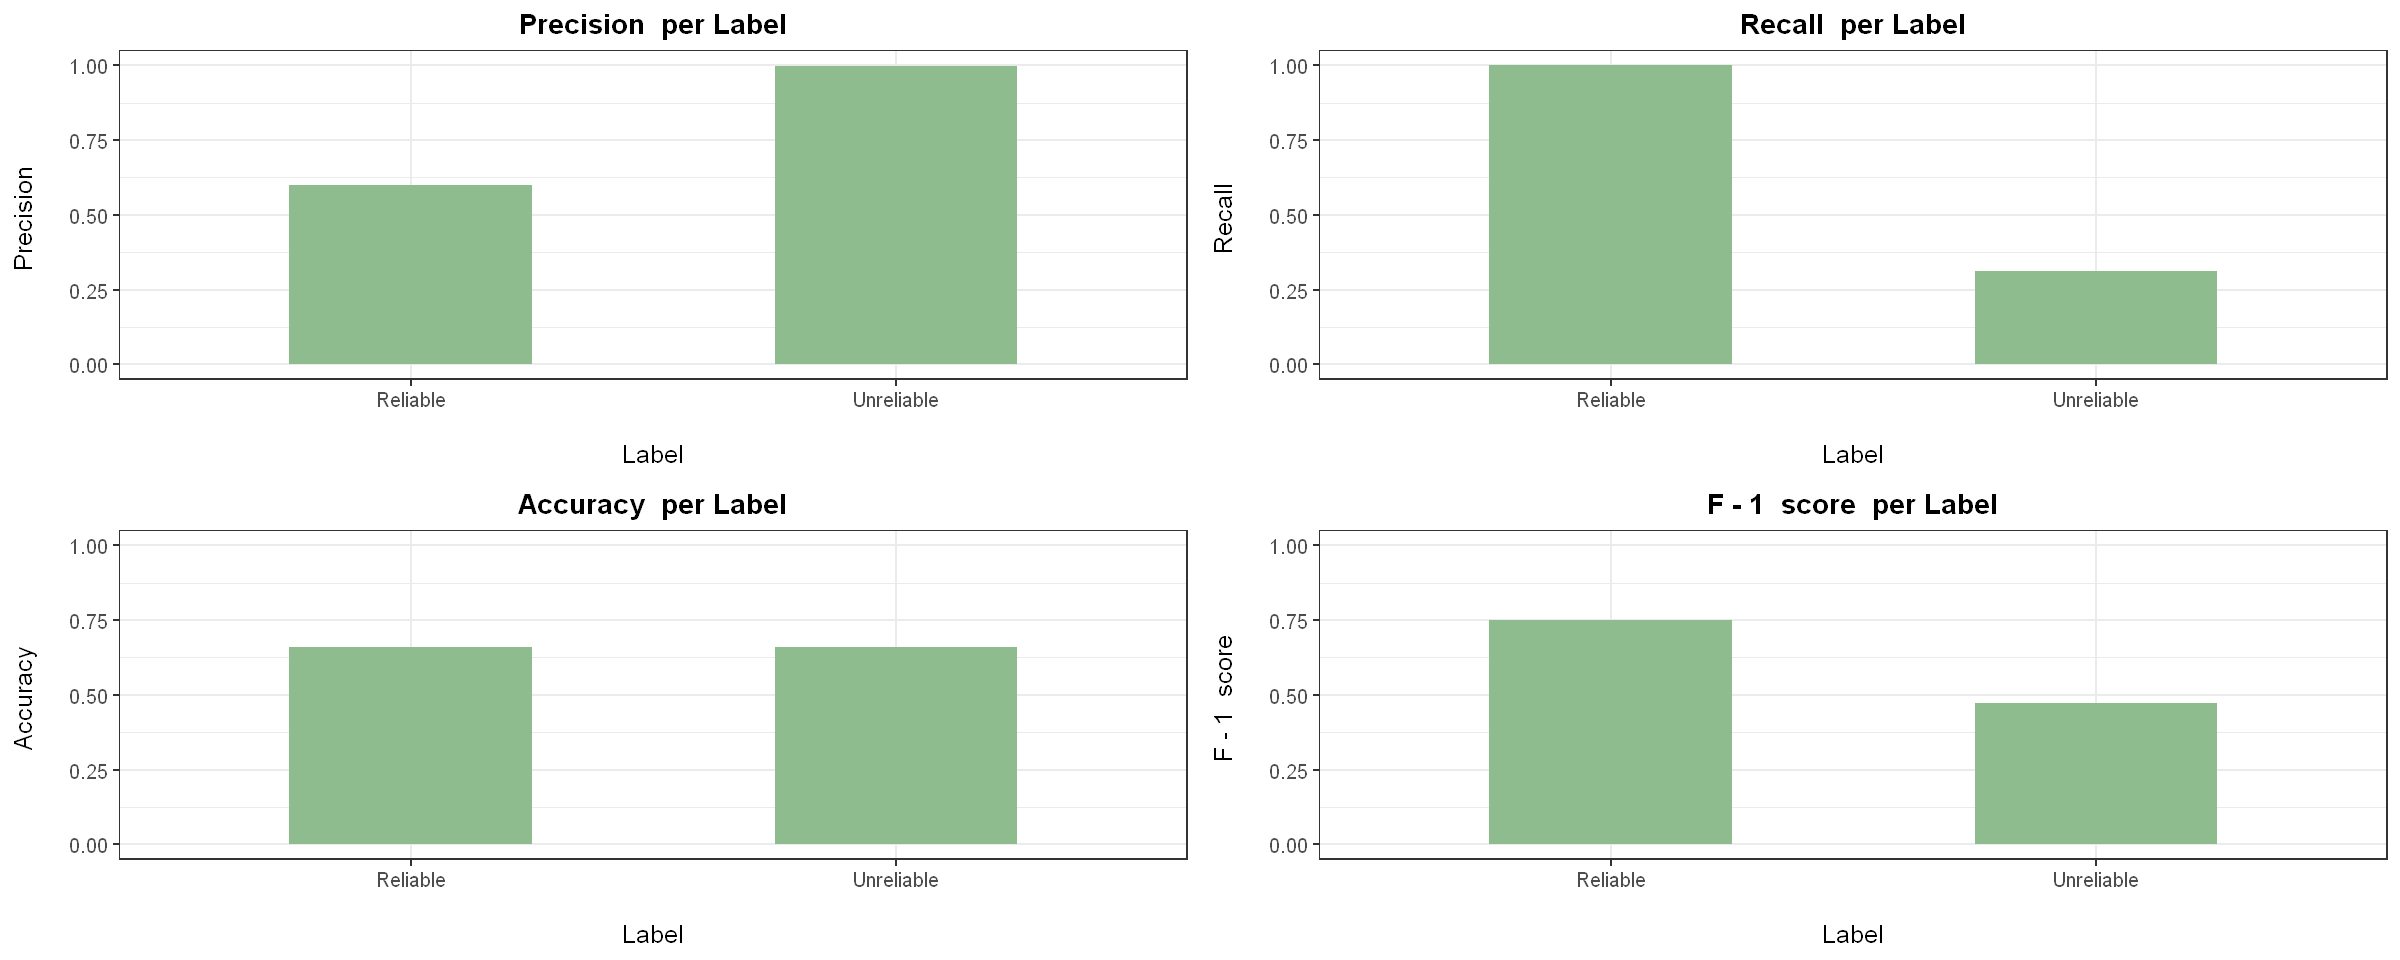

In [17]:
options(repr.plot.width = 20, repr.plot.height = 8)

fbeta_val <- 1

#Plot Bar plots of metric values for each label
for (tb in metric_list){

    accuracy_plot <- plot_bar(tb, 'acc', 'Accuracy')
    precision_plot <- plot_bar(tb, 'precision', 'Precision')
    recall_plot <- plot_bar(tb, 'recall', 'Recall')
    fbeta_plot <- plot_bar(tb, 'f_beta', paste('F -', fbeta_val, ' score'))

    grid.arrange(precision_plot, recall_plot,
                    accuracy_plot, fbeta_plot,
                    nrow=2, ncol=2,
                    padding = unit(5, 'cm'))

}